# Coefficient Estimation for NEWT

The optimal model involves eight seasonality coefficients and a baseline air temperature sensitivity, a total of nine terms.  We don't need to estimate anything for the relationship between seasonal temperature and sensitivity on a given day, since a global GAM does that.  So we have nine coefficients to estimate.

However, those nine coefficients are correlated, which raises problems for uncertainty analysis and, in general, suggests inefficiency.  So the first thing we're going to do is principle component analysis on the coefficients.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines
from NEWT.make_coefficients import build_training_data
import NEXT.data as ndata
import NEWT
from math import ceil
anomweights = np.array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [2]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [ ]:
data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]
data

id       date  temperature       prcp       srad  swe  \
0        13011820 2020-03-31     0.100000  17.110126  248.76216  NaN   
1        13011820 2020-04-01     0.100000   7.202532  403.38873  NaN   
2        13011820 2020-04-02     0.100000   2.167848  600.86993  NaN   
3        13011820 2020-04-03     0.100000   2.987468  509.44165  NaN   
4        13011820 2020-04-04     0.100000   6.021518  465.97583  NaN   
...           ...        ...          ...        ...        ...  ...   
2987895  03047000 2022-12-27     0.540625   0.000000  268.23563  NaN   
2987896  03047000 2022-12-28     0.407292   0.000000  279.93356  NaN   
2987897  03047000 2022-12-29     0.428125   0.000000  290.53482  NaN   
2987898  03047000 2022-12-30     0.661458   0.000000  285.53320  NaN   
2987899  03047000 2022-12-31     0.743750   3.910029  144.37915  NaN   

              tmax  tmin         vp  day  ...     slope  asp_north  asp_east  \
0         1.795443   NaN  444.26370   91  ...  0.000243   0.003187  0.002841   
1         0.030759   NaN  270.94354   92  ...  0.000243   0.003187  0.002841   
2        -3.442405   NaN  132.77936   93  ...  0.000243   0.003187  0.002841   
3        -2.238481   NaN  138.35303   94  ...  0.000243   0.003187  0.002841   
4         3.509114   NaN  284.43704   95  ...  0.000243   0.003187  0.002841   
...            ...   ...        ...  ...  ...       ...        ...       ...   
2987895  -2.151775   NaN  207.79785  361  ...  0.000671   0.004324  0.003170   
2987896   5.509683   NaN  310.02664  362  ...  0.000671   0.004324  0.003170   
2987897  13.100331   NaN  354.31638  363  ...  0.000671   0.004324  0.003170   
2987898  17.568270   NaN  512.88240  364  ...  0.000671   0.004324  0.003170   
2987899  12.166826   NaN  832.86690  365  ...  0.000671   0.004324  0.003170   

               lat         lon  year     canopy     flowdir  frozen  cold_prcp  
0        43.807111 -110.178722  2020  29.173334  260.527706   False   0.000000  
1        43.807111 -110.178722  2020  29.173334  260.527706   False   0.000000  
2        43.807111 -110.178722  2020  29.173334  260.527706    True   2.167848  
3        43.807111 -110.178722  2020  29.173334  260.527706    True   2.987468  
4        43.807111 -110.178722  2020  29.173334  260.527706   False   0.000000  
...            ...         ...   ...        ...         ...     ...        ...  
2987895  40.458889  -79.449444  2022  29.154762   12.102172    True   0.000000  
2987896  40.458889  -79.449444  2022  29.154762   12.102172   False   0.000000  
2987897  40.458889  -79.449444  2022  29.154762   12.102172   False   0.000000  
2987898  40.458889  -79.449444  2022  29.154762   12.102172   False   0.000000  
2987899  40.458889  -79.449444  2022  29.154762   12.102172   False   0.000000  

[2987900 rows x 33 columns]

In [ ]:
data.drop(columns="date").describe()

temperature          prcp          srad            swe          tmax  \
count  2.987900e+06  2.987900e+06  2.987900e+06  578400.000000  2.987900e+06   
mean   1.304480e+01  3.425176e+00  3.273382e+02      17.926649  1.688383e+01   
std    7.778464e+00  8.017643e+00  1.310696e+02      49.761395  1.065262e+01   
min   -4.989583e-01  0.000000e+00  1.599158e+01       0.000000 -2.844553e+01   
25%    6.691667e+00  0.000000e+00  2.272068e+02       0.000000  8.669371e+00   
50%    1.255729e+01  0.000000e+00  3.281181e+02       0.000000  1.786824e+01   
75%    1.918229e+01  3.160186e+00  4.291651e+02       7.820107  2.572708e+01   
max    3.999688e+01  2.717640e+02  8.285261e+02     750.342160  4.495986e+01   

               tmin            vp           day         water     developed  \
count  1.433446e+06  2.987900e+06  2.987900e+06  2.987900e+06  2.987900e+06   
mean   5.062516e+00  9.831255e+02  1.872229e+02  1.268352e-02  1.478107e-01   
std    9.425389e+00  6.475989e+02  1.040032e+02  2.060045e-02  2.192455e-01   
min   -3.810106e+01  1.937390e+01  1.000000e+00  0.000000e+00  0.000000e+00   
25%   -1.216429e+00  5.072167e+02  9.900000e+01  1.829815e-03  1.931167e-02   
50%    5.120216e+00  7.729694e+02  1.890000e+02  5.872330e-03  5.986721e-02   
75%    1.199073e+01  1.328157e+03  2.770000e+02  1.551254e-02  1.489284e-01   
max    2.819078e+01  3.693103e+03  3.650000e+02  2.316803e-01  9.849686e-01   

       ...      elev_std         slope     asp_north      asp_east  \
count  ...  2.987900e+06  2.987900e+06  2.987900e+06  2.987900e+06   
mean   ...  1.942447e+02  1.884932e-03  7.355827e-03 -1.552842e-03   
std    ...  2.216071e+02  2.532902e-03  1.024769e-02  1.524831e-02   
min    ...  1.231675e+00  4.762368e-05 -1.538242e-02 -2.824883e-01   
25%    ...  3.074977e+01  4.481627e-04  3.460877e-03 -2.773193e-03   
50%    ...  1.143489e+02  9.428893e-04  5.018477e-03  2.168743e-03   
75%    ...  2.930310e+02  2.337958e-03  8.388438e-03  3.922721e-03   
max    ...  1.427199e+03  3.008171e-02  2.041745e-01  1.524249e-02   

                lat           lon          year        canopy       flowdir  \
count  2.987900e+06  2.987900e+06  2.987900e+06  2.987900e+06  2.987900e+06   
mean   3.992888e+01 -9.565336e+01  2.016161e+03  3.147648e+01  1.888851e+02   
std    4.613372e+00  1.749465e+01  4.168676e+00  2.808762e+01  9.836393e+01   
min    2.697500e+01 -1.243930e+02  2.004000e+03  0.000000e+00  5.787924e-01   
25%    3.731277e+01 -1.120107e+02  2.013000e+03  4.000000e+00  1.047749e+02   
50%    4.005460e+01 -8.861419e+01  2.017000e+03  2.404255e+01  1.992379e+02   
75%    4.325386e+01 -8.047256e+01  2.020000e+03  5.741737e+01  2.747320e+02   
max    4.899881e+01 -6.780389e+01  2.022000e+03  9.486487e+01  3.586496e+02   

          cold_prcp  
count  2.987900e+06  
mean   1.473491e-01  
std    1.352327e+00  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    8.861503e+01  

[8 rows x 30 columns]

## Add Reach Buffer Data 

For each site, we want 1-km-upstream, 15-m-buffer canopy cover and mean direction.  Conveniently, flow direction maps exactly onto slope aspect of the river itself, since by definition it flows precisely downhill.  Runtime depends on period of record, but is currently averaging 15 seconds per site (suggesting ~4 hours for all of them).

## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [ ]:
def make_coefficients(grp):
    if len(grp["day"].unique()) < 181:
        return None
    anomilized = NEWT.watershed.anomilize(grp).sort_values("date")[["date", "st_anom", "at_anom"]]  # st_anom, at_anom
    ssn = rts.ThreeSine.from_data(grp[["day", "temperature"]]).to_df().drop(columns=["RMSE", "R2"])
    for i in range(6):
        anomilized[f"delta{i}"] = anomilized["at_anom"].shift(i)
    anomilized = anomilized.dropna()
    X = anomilized.loc[:, "delta0":"delta5"]
    y = anomilized["st_anom"]
    prd = X @ anomweights
    ssn["sensitivity"] = y.abs().mean() / prd.abs().mean()
    return ssn

In [ ]:
coefs = data.groupby("id").apply(make_coefficients, include_groups=False).droplevel(1)
coefs.describe()

Intercept   Amplitude     FallDay   WinterDay   SpringDay   SummerDay  \
count  921.000000  921.000000  921.000000  921.000000  921.000000  921.000000   
mean    12.740453    8.882257  326.754615   66.920738  154.070575  217.706840   
std      3.993507    2.723280   15.606734   32.471655   21.642059   17.322166   
min      3.085846    0.182583  300.000000    1.000000  120.000000  200.000000   
25%      9.907242    7.209934  317.000000   33.000000  135.000000  200.000000   
50%     12.520833    9.357408  327.000000   84.000000  156.000000  212.000000   
75%     14.876002   10.884484  333.000000   90.000000  177.000000  238.000000   
max     30.100749   15.907383  365.000000  110.000000  180.000000  240.000000   

       SpringSummer  FallWinter  sensitivity  
count    921.000000  921.000000   921.000000  
mean       0.739229    1.398353     0.610153  
std        0.955179    0.920338     0.166154  
min       -2.585014   -2.453322     0.072260  
25%        0.062890    0.828810     0.504472  
50%        0.471416    1.409035     0.612575  
75%        1.199086    1.924694     0.708648  
max        4.922727    4.801733     1.641213

In [ ]:
coefs.corr()

Intercept  Amplitude   FallDay  WinterDay  SpringDay  SummerDay  \
Intercept      1.000000   0.131512  0.164127   0.404417   0.369917   0.129456   
Amplitude      0.131512   1.000000 -0.376684   0.274517  -0.066560  -0.272210   
FallDay        0.164127  -0.376684  1.000000  -0.146802   0.101235   0.353745   
WinterDay      0.404417   0.274517 -0.146802   1.000000   0.425964  -0.200349   
SpringDay      0.369917  -0.066560  0.101235   0.425964   1.000000   0.147555   
SummerDay      0.129456  -0.272210  0.353745  -0.200349   0.147555   1.000000   
SpringSummer  -0.470499  -0.231572  0.021123  -0.393230  -0.263417   0.164909   
FallWinter     0.084135   0.475000 -0.409584   0.208566   0.020473  -0.444835   
sensitivity    0.492256   0.324733 -0.014003   0.390718   0.226161  -0.027600   

              SpringSummer  FallWinter  sensitivity  
Intercept        -0.470499    0.084135     0.492256  
Amplitude        -0.231572    0.475000     0.324733  
FallDay           0.021123   -0.409584    -0.014003  
WinterDay        -0.393230    0.208566     0.390718  
SpringDay        -0.263417    0.020473     0.226161  
SummerDay         0.164909   -0.444835    -0.027600  
SpringSummer      1.000000   -0.142387    -0.276137  
FallWinter       -0.142387    1.000000     0.154128  
sensitivity      -0.276137    0.154128     1.000000

## PCA

In [ ]:
offset = coefs.mean()
scale = coefs.std()

In [ ]:
co_norm = (coefs - offset) / scale
co_norm

Intercept  Amplitude   FallDay  WinterDay  SpringDay  \
id                                                                      
01010000         -1.130066   1.021655 -0.240577  -1.214005  -1.574276   
01011000         -1.049903   1.047799 -0.304651  -1.229403  -1.574276   
01018035         -0.917866   1.147696 -0.368726  -1.198607  -1.574276   
01038000         -0.468065   1.303961 -0.496876  -1.229403   0.689834   
010642505        -1.128699   0.136050 -0.368726  -1.260199  -1.481863   
...                    ...        ...       ...        ...        ...   
385903107210800  -1.396608   0.138243 -1.714299   0.618363  -0.511531   
394220106431500  -1.446208  -0.559981 -0.176502   0.525974   0.089152   
402114105350101  -2.100451  -0.566682 -1.650224   0.649159  -0.049467   
404417108524900  -0.780433  -0.306391  0.207948   0.248810   0.135358   
453004122510301   0.088873  -0.617728  0.207948   0.556771   0.181564   

                 SummerDay  SpringSummer  FallWinter  sensitivity  
id                                                                 
01010000          1.056055      1.309115    2.033523     0.489697  
01011000         -0.791289      1.909678    1.465106    -0.274307  
01018035         -0.675830      1.150649    1.272012    -0.071815  
01038000         -1.022207      0.167929    0.616852    -0.047298  
010642505         0.882866      1.075481   -0.399632    -0.740959  
...                    ...           ...         ...          ...  
385903107210800  -0.964478      1.407457    0.012322     0.731924  
394220106431500   1.113784      2.182419    0.630962    -0.651740  
402114105350101   1.113784      1.838226   -0.449870    -0.296076  
404417108524900  -0.791289      1.129490   -0.487248    -0.620981  
453004122510301  -0.733560     -0.379148    0.381372     0.469942  

[921 rows x 9 columns]

There are some nontrivial cross-correlations, so let's see what the principal component axes look like.

In [ ]:
pca = PCA()
fit = pca.fit(co_norm)
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.31064119 0.23023392 0.0997021  0.08744718 0.06906775 0.0669102
 0.0544088  0.04657232 0.03501653]
[0.31064119 0.54087511 0.64057721 0.7280244  0.79709215 0.86400235
 0.91841115 0.96498347 1.        ]


Of the 9 coefficients, we capture 96% of the variance with 8 of them, 92% with 7, 86% with 6, etc.  But that's not the point: we're looking to predict uncorrelated variables, not compress the space.

<Axes: >

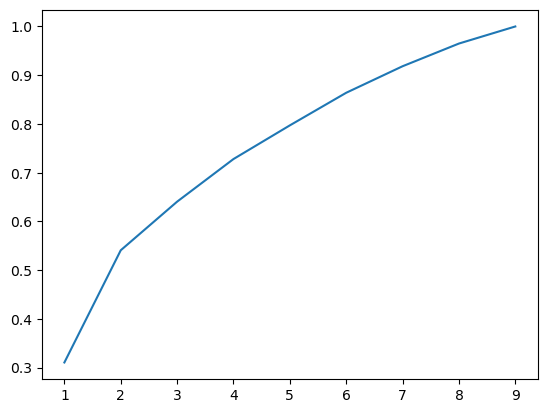

In [ ]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

In [ ]:
pcax = pd.DataFrame(fit.components_,
            columns=coefs.columns)  # shape: components x features. So a row is a PC and a column is a feature.
pcax

Intercept  Amplitude   FallDay  WinterDay  SpringDay  SummerDay  \
0  -0.363554  -0.362537  0.189785  -0.440122  -0.245282   0.217008   
1   0.384914  -0.298407  0.465604   0.122439   0.373586   0.433435   
2   0.215154   0.425689  0.146019  -0.320762  -0.532928   0.312579   
3  -0.132097   0.120263 -0.366896   0.147857   0.422611   0.439072   
4  -0.076198  -0.267996  0.408149   0.202243  -0.036851  -0.528856   
5  -0.222028   0.015635 -0.361087   0.408794  -0.248073  -0.067837   
6   0.358773  -0.616560 -0.536250  -0.330232  -0.083683  -0.061839   
7  -0.471265   0.124673  0.013424  -0.521155   0.454387  -0.152122   
8  -0.500018  -0.340721  0.080909   0.279072  -0.247567   0.404099   

   SpringSummer  FallWinter  sensitivity  
0      0.381405   -0.327031    -0.383399  
1     -0.160753   -0.381675     0.179071  
2      0.126520   -0.026028     0.499886  
3      0.630803    0.102800     0.178181  
4      0.481932    0.064311     0.444345  
5     -0.082125   -0.731915     0.210658  
6     -0.033354    0.075731     0.277207  
7     -0.280787   -0.144953     0.401400  
8     -0.309535    0.411761     0.243966

So what's actually going into this stuff?  From most important to least:

0. Distributed across pretty much everything except Fall, Spring, and Summer days.
1. Heavy on the three days omitted before, plus some weight on Intercept, Amplitude, and FallWinter.
2. Heavy on SpringDay and sensitivity with some Amplitude.
3. Heavy on SpringSummer and Summer, Spring and Fall days
4. SummerDay, SpringSummer, and sensitivity
5. FallWinter, with a little Fall and Winter days
6. Amplitude and FallDay
7. WinterDay, SpringDay, and Intercept
8. Intercept, SummerDay, and FallWinter

Note that all components and all features have roughly equal total absolute weights, just distributed differently.  Total non-absolute weights are quite variable.

<Axes: >

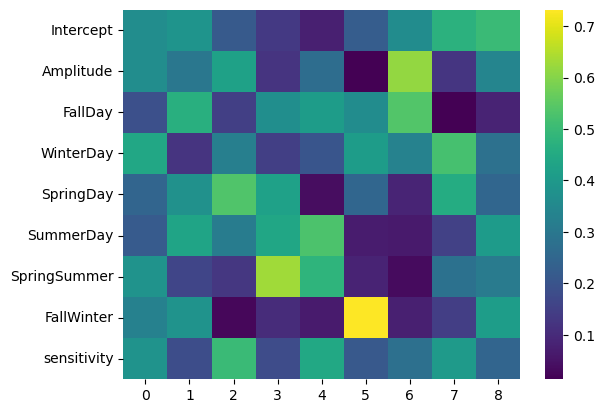

In [ ]:
sns.heatmap(pcax.T.abs(), cmap="viridis")

As a sanity check, coefficients x t(PCA) should give us 9 uncorrelated variables.  It works!  And we invert it by multiplying by (non-transposed) PCA components.

In [ ]:
comps = co_norm @ np.transpose(fit.components_)
comps.columns = [f"pca{x}" for x in range(9)]
comps.corr()

pca0          pca1          pca2          pca3          pca4  \
pca0  1.000000e+00 -1.662446e-16  2.428939e-16  2.022454e-16  1.319097e-16   
pca1 -1.662446e-16  1.000000e+00  2.952801e-16  2.007786e-16  2.358941e-16   
pca2  2.428939e-16  2.952801e-16  1.000000e+00  2.784765e-16  6.632897e-17   
pca3  2.022454e-16  2.007786e-16  2.784765e-16  1.000000e+00  3.300535e-16   
pca4  1.319097e-16  2.358941e-16  6.632897e-17  3.300535e-16  1.000000e+00   
pca5 -1.693889e-16 -3.021370e-16  1.896367e-16  5.028784e-16  1.357508e-16   
pca6 -1.472285e-16 -1.433869e-17  3.504938e-16  6.317653e-18 -1.320033e-16   
pca7 -3.240018e-16  2.150218e-18 -7.738375e-17 -1.544197e-16 -3.438017e-16   
pca8  1.688667e-16  3.084960e-16  2.282912e-16 -4.036876e-16  7.729631e-17   

              pca5          pca6          pca7          pca8  
pca0 -1.693889e-16 -1.472285e-16 -3.240018e-16  1.688667e-16  
pca1 -3.021370e-16 -1.433869e-17  2.150218e-18  3.084960e-16  
pca2  1.896367e-16  3.504938e-16 -7.738375e-17  2.282912e-16  
pca3  5.028784e-16  6.317653e-18 -1.544197e-16 -4.036876e-16  
pca4  1.357508e-16 -1.320033e-16 -3.438017e-16  7.729631e-17  
pca5  1.000000e+00 -3.111299e-16 -1.879436e-16  2.704840e-16  
pca6 -3.111299e-16  1.000000e+00 -5.361355e-16 -3.224356e-16  
pca7 -1.879436e-16 -5.361355e-16  1.000000e+00 -5.017827e-17  
pca8  2.704840e-16 -3.224356e-16 -5.017827e-17  1.000000e+00

In [ ]:
fit.components_

array([[-0.3635536 , -0.36253655,  0.18978457, -0.4401217 , -0.24528224,
         0.21700805,  0.38140546, -0.3270315 , -0.38339944],
       [ 0.38491387, -0.29840726,  0.46560378,  0.12243858,  0.37358605,
         0.43343509, -0.16075314, -0.381675  ,  0.17907109],
       [ 0.21515426,  0.42568867,  0.14601904, -0.32076195, -0.53292759,
         0.31257888,  0.12651994, -0.02602839,  0.49988585],
       [-0.13209679,  0.1202627 , -0.36689606,  0.14785714,  0.42261061,
         0.43907167,  0.63080335,  0.10279969,  0.17818129],
       [-0.07619769, -0.26799642,  0.40814928,  0.20224315, -0.03685127,
        -0.52885627,  0.4819317 ,  0.06431149,  0.44434513],
       [-0.22202771,  0.01563487, -0.361087  ,  0.40879354, -0.24807321,
        -0.06783746, -0.08212493, -0.7319151 ,  0.21065805],
       [ 0.35877293, -0.61655974, -0.53625048, -0.33023217, -0.08368292,
        -0.06183943, -0.03335436,  0.0757308 ,  0.27720677],
       [-0.47126455,  0.1246728 ,  0.0134238 , -0.52115533,  0

In [ ]:
coefs_rc = comps @ fit.components_
coefs_rc.columns = coefs.columns
coefs_rc = coefs_rc * scale + offset
coefs_rc - coefs

Intercept     Amplitude  FallDay     WinterDay  \
id                                                                   
01010000         1.065814e-14 -1.776357e-15      0.0  2.131628e-14   
01011000         7.105427e-15 -3.552714e-15      0.0  3.552714e-14   
01018035         5.329071e-15 -1.776357e-15      0.0  3.552714e-14   
01038000         1.776357e-15 -1.776357e-15      0.0  1.421085e-14   
010642505        8.881784e-15  1.776357e-15      0.0  3.552714e-14   
...                       ...           ...      ...           ...   
385903107210800  3.552714e-15  0.000000e+00      0.0  2.842171e-14   
394220106431500  7.105427e-15  1.776357e-15      0.0  2.842171e-14   
402114105350101  7.105427e-15  3.552714e-15      0.0  2.842171e-14   
404417108524900  0.000000e+00  0.000000e+00      0.0  4.263256e-14   
453004122510301  0.000000e+00 -8.881784e-16      0.0  0.000000e+00   

                    SpringDay  SummerDay  SpringSummer    FallWinter  \
id                                                                     
01010000         2.842171e-14        0.0  0.000000e+00 -1.776357e-15   
01011000         2.842171e-14        0.0  0.000000e+00 -8.881784e-16   
01018035         2.842171e-14        0.0 -4.440892e-16 -8.881784e-16   
01038000         0.000000e+00        0.0 -5.551115e-16 -2.220446e-16   
010642505        2.842171e-14        0.0 -1.110223e-15  4.440892e-16   
...                       ...        ...           ...           ...   
385903107210800  0.000000e+00        0.0  8.881784e-16 -1.110223e-15   
394220106431500  2.842171e-14        0.0  4.440892e-16  0.000000e+00   
402114105350101  0.000000e+00        0.0 -4.440892e-16 -7.771561e-16   
404417108524900  0.000000e+00        0.0  0.000000e+00  4.440892e-16   
453004122510301  0.000000e+00        0.0  7.771561e-16 -4.440892e-16   

                  sensitivity  
id                             
01010000         0.000000e+00  
01011000         1.110223e-16  
01018035         0.000000e+00  
01038000        -1.110223e-16  
010642505        5.551115e-17  
...                       ...  
385903107210800  1.110223e-16  
394220106431500  0.000000e+00  
402114105350101  0.000000e+00  
404417108524900  1.110223e-16  
453004122510301  0.000000e+00  

[921 rows x 9 columns]

# Model

We'll use a GAM.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).

## Generalized Code

In [ ]:
preds = NEWT.coef_est.preprocess(data).drop(columns=["level_1_x", "level_1_y", "date", "day"])
preds.columns

Index(['id', 'tmax', 'prcp', 'srad', 'vp', 'area', 'elev_min', 'elev', 'slope',
       'forest', 'wetland', 'developed', 'ice_snow', 'water', 'canopy',
       'flowdir', 'lat', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'srad_sd',
       'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'],
      dtype='object')

In [ ]:
mdata = comps.merge(preds, on="id", how="left")

In [ ]:
X = mdata.iloc[:, 10:]
allvar = X.columns
Y = mdata.loc[:, "pca0":"pca8"]

In [ ]:
allvar

Index(['tmax', 'prcp', 'srad', 'vp', 'area', 'elev_min', 'elev', 'slope',
       'forest', 'wetland', 'developed', 'ice_snow', 'water', 'canopy',
       'flowdir', 'lat', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'srad_sd',
       'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'],
      dtype='object')

In [ ]:
# Reference linear model
Xnp = np.concatenate((np.ones((len(X), 1)), X.to_numpy()), axis=1)
fit = np.linalg.lstsq(Xnp, Y, rcond=None)[0]
prd = Xnp @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(Y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[Y.columns[i]])
    for i in range(len(Y.columns))
])

R2
pca0  0.591425
pca1  0.530811
pca2  0.283742
pca3  0.247609
pca4  0.185949
pca5  0.366616
pca6  0.361475
pca7  0.234895
pca8  0.168749

After PCA, the best-variable linear performance is much worse, at 0.59.  We'll see how the GAM does.

In [345]:
eqmk = lambda N: sum([s(i) for i in range(1, N)], start=s(0))
without = lambda l, v: [i for i in l if i != v]

def gam_gcv(X, Y, eq, lam):
    return LinearGAM(eq, lam=lam).fit(X, Y).statistics_["GCV"]

def tune_lam(X, Y, lams, counter=0, tolerance=0.001, maxdepth=100, debug=False):
    # Lams: 3 lambda candidates (low, mid, high)
    # Tolerance: minimum change in GCV to proceed.
    print("|", end="")
    eq = eqmk(len(X.columns))
    (l, m, r) = lams
    left = gam_gcv(X, Y, eq, l)
    mid = gam_gcv(X, Y, eq, m)
    right = gam_gcv(X, Y, eq, r)
    if debug:
        print(f"{l} = {left} | {m} = {mid} | {r} = {right}")
    # First, we compute the improvement, the new set, and the reference
    # option.  After that, we'll decide whether to keep iterating.
    # Spacing is computed by powers of 10.
    if (delta := mid - left) > 0:  # low is good
        ref = l
        nl = (l/10, l, l * (m/l)**(1/2))
    elif (delta := mid - right) > 0:  # high is good
        ref = r
        nl = (m * (r/m)**(1/2), r, r*10)
    else:
        delta = mid - min([left, right])
        ref = m
        nl = (m * (l/m)**(1/2), m, m * (r/m)**(1/2))
    # Now we decide whether to proceed or return.
    if delta > tolerance and counter < maxdepth:
        return tune_lam(X, Y, nl, counter+1, tolerance, maxdepth, debug)
    else:
        return ref

def tune_gcv(varset, lam, gcv, X, Y, tolerance=0.0001, debug=False):
    # Iteratively tune a GAM to optimize GCV.  In each round, we optimize lambda and drop one variable.
    # Proceed only if we reduce GCV.  Otherwise, return the current arrangement.
    varset = varset.copy()
    if gcv is None:
        gcv = gam_gcv(X[varset], Y, eqmk(len(varset)), lam)
    # First pass: tune lambda.
    lam = tune_lam(X[varset], Y, (lam/3, lam, lam*3))
    # Next: drop one variable.
    best_gcv = gcv
    best_var = None
    if debug:
        print(gcv)
    for v in varset:
        new_vars = without(varset, v)
        new_gcv = gam_gcv(X[new_vars], Y, eqmk(len(new_vars)), lam)
        if debug:
            print(v, new_gcv)
        if new_gcv < best_gcv:
            best_gcv = new_gcv
            best_var = v
    if best_var is None or gcv - best_gcv < tolerance:
        return (varset, lam, gcv)
    else:
        varset.remove(best_var)
        print(f"Lambda: {lam:.2f} | Dropped: {best_var} | GCV: {best_gcv:.4f}")
        return tune_gcv(varset, lam, best_gcv, X, Y, tolerance)


def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms) - 1
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx] if Ny > 1 else axes[i]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_xlabel(repr(term) if names is None else names[i])
        if ylab is not None and i % Nx == 0:
            ax.set_ylabel(ylab)
    plt.tight_layout()
    if save is not None:
        plt.savefig(bp + save)

        
def pdps_by_x(named_gams, savebase):
    # Generate PDPs, as above, but by x-variable, not y-variable.
    # named_gams should be a list of tuples: (gam, xnames, simple_xnames, yname).
    # They will be saved as savebase + simple_xname + .png.
    xes = {}
    for (gam, xns, sxns, yn) in named_gams:
        terms = [t for t in gam.terms if not t.isintercept]
        for (i, sxn) in enumerate(sxns):
            if not sxn in xes:
                xes[sxn] = {"xlab": xns[i], "ys": []}
            gxg = gam.generate_X_grid(term=i)
            X = gxg[:, terms[i].feature]
            pdep, confi = gam.partial_dependence(term=i, X=gxg, width=0.95)
            xes[sxn]["ys"].append((
                yn, X, pdep, confi
            ))
    for (sxn, vals) in xes.items():
        ys = vals["ys"]
        nt = len(ys)
        nrow = int(nt ** 0.5)
        ncol = ceil(nt / nrow)
        _, axes = plt.subplots(nrow, ncol, figsize=(12, 8))
        for (i, Y) in enumerate(ys):
            ax = axes[i // ncol, i % ncol] if nrow > 1 else axes[i] if nt > 1 else axes
            xs = Y[1]
            ax.plot(xs, Y[2])
            ax.plot(xs, Y[3], c='r', ls='--')
            ax.set_ylabel(Y[0])
            if i // ncol == nrow - 1:
                ax.set_xlabel(vals["xlab"])
        plt.tight_layout()
        plt.savefig(savebase + sxn + ".png", dpi=1200)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)

In [ ]:
varname = {
    'intercept': "Mean Air Temperature (C)",
    'prcp': "Mean Precipitation (mm/day)",
    'cold_prcp': "Mean Subfreezing Precip (mm/day)",
    'frozen': "Proportion of Days Below Freezing",
    'srad': "Mean Solar Radiation (W/m2)",
    'water': "Water Land Cover Fraction",
    'developed': "Developed Land Cover Fraction",
    'barren': "Barren Land Cover Fraction",
    'forest': "Forest Land Cover Fraction",
    'shrubland': "Shrubland Land Cover Fraction",
    'herbaceous': "Herbaceous Land Cover Fraction",
    'cultivated': "Cultivated Land Cover Fraction",
    'wetland': "Wetland Land Cover Fraction",
    'ice_snow': "Ice/Snow Land Cover Fraction",
    'canopy': "Last-km Riparian Canopy Cover (%)",
    'flowdir': "Mean Last-km Flow Direction (deg)", 
    'area': "Watershed Area (m2)",
    'elev': "Mean Elevation (m)",
    'elev_min': "Min Elevation (m)",
    'slope': "Watershed Mean Slope (m/m)",
    'asp_north': "Slope Aspect Mean North Component",
    'asp_east': "Slope Aspect Mean East Component",
    'lat': "Latitude (deg N)",
    'lon': "Longitude (deg E)",
    'prcp_sd': "Std Dev Precipitation (mm/day)",
    'srad_sd': "Std Dev Solar Radiation (W/m2)",
    'vp': 'Mean Vapor Pressure (Pa)',
    'vp_sd': "Std Dev Vapor Pressure (Pa)",
    'prcp_phi': "Mean Date of Precip (Julian day)",
    'prcp_index': "Precip Seasonality Index",
    'tmax': 'Mean Daily Max Air Temp (C)',
    'tmax_phi': 'Mean Date of Air Temp (Julian day)',
    'tmax_index': 'Air Temp Seasonality Index',
    "Intercept": "3S Intercept (C)",
    "Amplitude": "3S Amplitude (C)"
}
rename = lambda vrs: [varname[v] for v in vrs]

## PCA0

In [354]:
(var0, lam0, gcv0) = tune_gcv(list(allvar), 10, None, X, Y["pca0"])
print(var0, lam0, gcv0)
eq0 = eqmk(len(var0))
gam0 = LinearGAM(eq0, lam=lam0).fit(X[var0], Y["pca0"])
gam0.summary()

|||||Lambda: 948.68 | Dropped: flowdir | GCV: 1.2082
|Lambda: 948.68 | Dropped: prcp_index | GCV: 1.2017
|Lambda: 948.68 | Dropped: canopy | GCV: 1.1964
|Lambda: 948.68 | Dropped: elev | GCV: 1.1916
|Lambda: 948.68 | Dropped: prcp_sd | GCV: 1.1868
|Lambda: 948.68 | Dropped: developed | GCV: 1.1822
|Lambda: 316.23 | Dropped: prcp | GCV: 1.1751
|Lambda: 316.23 | Dropped: srad_sd | GCV: 1.1696
|Lambda: 316.23 | Dropped: prcp_phi | GCV: 1.1641
|Lambda: 105.41 | Dropped: frozen | GCV: 1.1573
|Lambda: 105.41 | Dropped: tmax_index | GCV: 1.1501
|Lambda: 105.41 | Dropped: cold_prcp | GCV: 1.1448
|||Lambda: 60.86 | Dropped: area | GCV: 1.1370
|Lambda: 60.86 | Dropped: elev_min | GCV: 1.1322
|Lambda: 60.86 | Dropped: vp | GCV: 1.1290
|Lambda: 60.86 | Dropped: slope | GCV: 1.1266
|Lambda: 60.86 | Dropped: ice_snow | GCV: 1.1238
||['tmax', 'srad', 'forest', 'wetland', 'water', 'lat', 'lon', 'vp_sd', 'tmax_phi'] 35.13641844631532 1.1237820439397528
LinearGAM                                         

/tmp/ipykernel_934270/4069590261.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam0.summary()


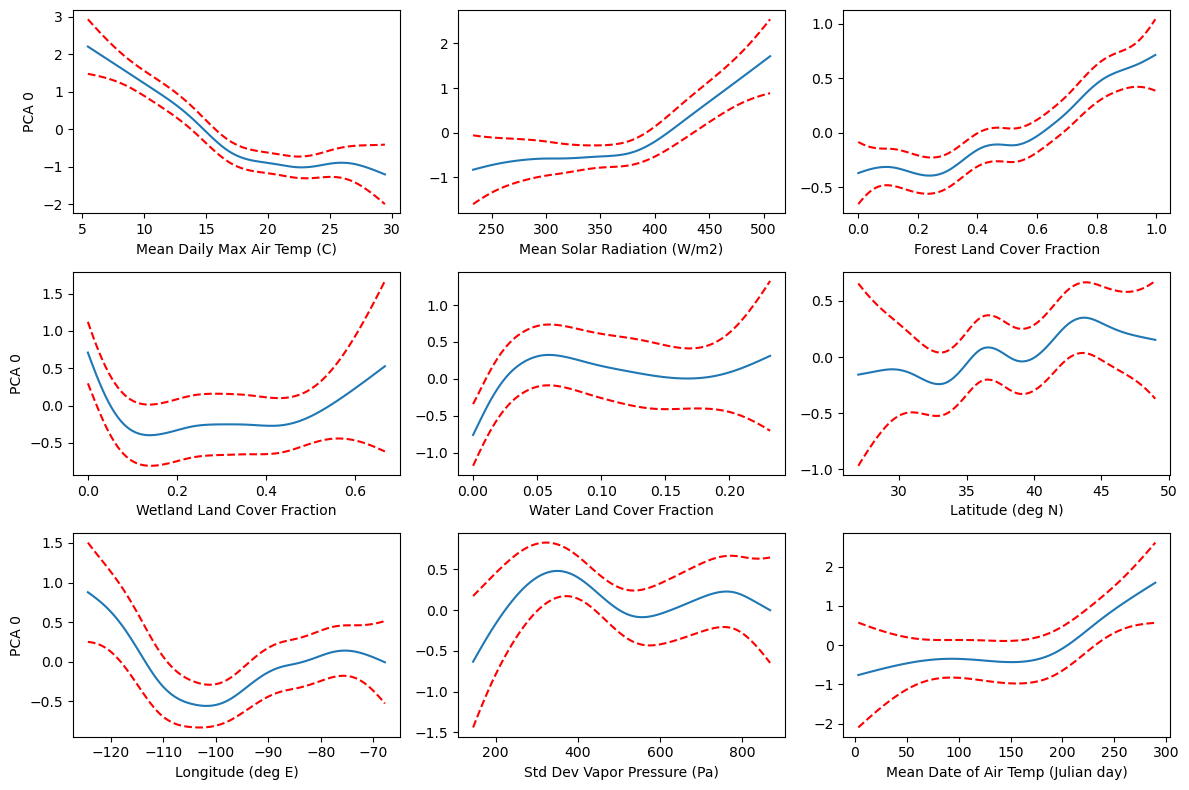

In [355]:
pdps(gam0, False, rename(var0), "PCA 0", "results/PCA_PDPs/GAM0.png")

## PCA1

In [356]:
(var1, lam1, gcv1) = tune_gcv(list(allvar), 10, None, X, Y["pca1"])
print(var1, lam1, gcv1)
eq1 = eqmk(len(var1))
gam1 = LinearGAM(eq1, lam=lam1).fit(X[var1], Y["pca1"])
gam1.summary()

|||Lambda: 300.00 | Dropped: canopy | GCV: 1.0257
|Lambda: 100.00 | Dropped: prcp_index | GCV: 1.0169
|Lambda: 100.00 | Dropped: area | GCV: 1.0088
|Lambda: 100.00 | Dropped: prcp | GCV: 1.0016
|Lambda: 100.00 | Dropped: prcp_sd | GCV: 0.9953
|Lambda: 100.00 | Dropped: prcp_phi | GCV: 0.9883
|||Lambda: 43.87 | Dropped: srad_sd | GCV: 0.9777
|Lambda: 43.87 | Dropped: flowdir | GCV: 0.9703
|Lambda: 43.87 | Dropped: tmax | GCV: 0.9643
|Lambda: 43.87 | Dropped: tmax_index | GCV: 0.9581
|||Lambda: 25.33 | Dropped: cold_prcp | GCV: 0.9503
|Lambda: 25.33 | Dropped: tmax_phi | GCV: 0.9464
|Lambda: 25.33 | Dropped: developed | GCV: 0.9447
|Lambda: 25.33 | Dropped: ice_snow | GCV: 0.9440
|['srad', 'vp', 'elev_min', 'elev', 'slope', 'forest', 'wetland', 'water', 'lat', 'lon', 'frozen', 'vp_sd'] 25.327856188386416 0.9440378905570945
LinearGAM                                                                                                 
=============================================== ============

/tmp/ipykernel_934270/2160680795.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam1.summary()


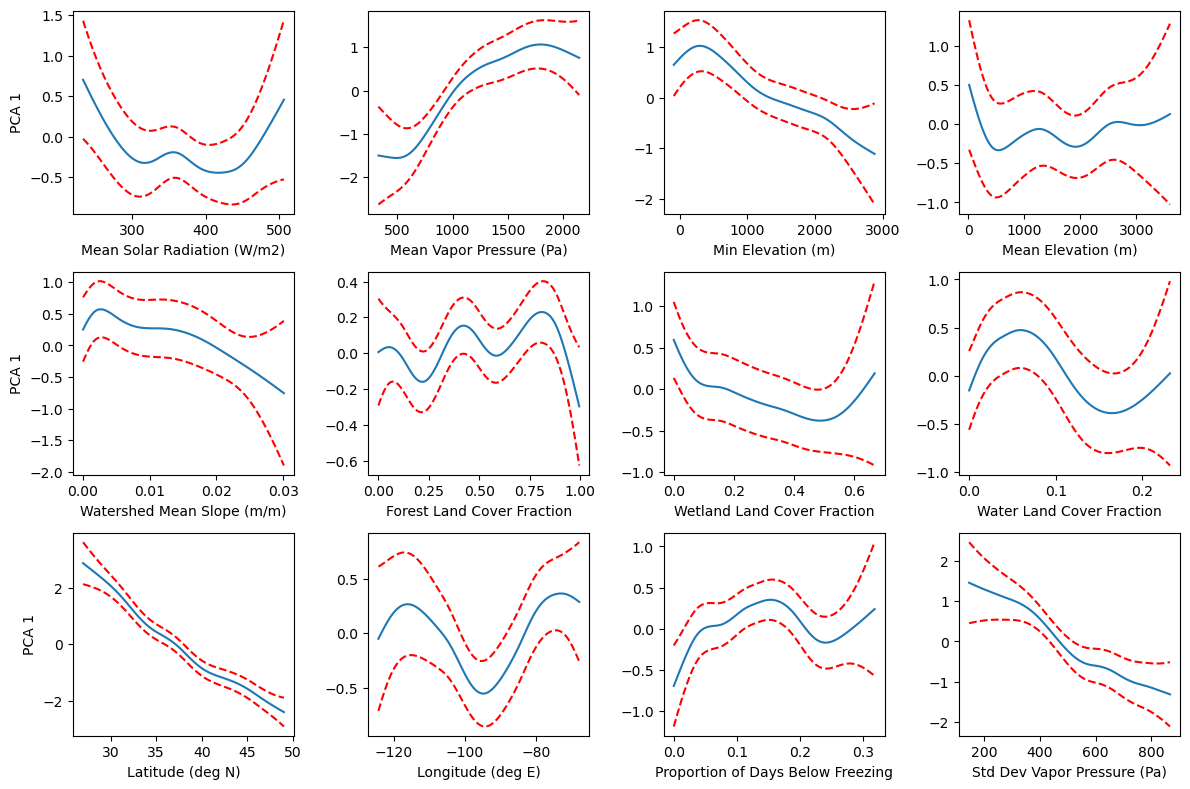

In [357]:
pdps(gam1, False, rename(var1), "PCA 1", "results/PCA_PDPs/GAM1.png")

## PCA2

In [358]:
(var2, lam2, gcv2) = tune_gcv(list(allvar), 12, None, X, Y["pca2"])
print(var2, lam2, gcv2)
eq2 = eqmk(len(var2))
gam2 = LinearGAM(eq2, lam=lam2).fit(X[var2], Y["pca2"])
gam2.summary()

|||Lambda: 360.00 | Dropped: flowdir | GCV: 0.6781
|Lambda: 1080.00 | Dropped: prcp_sd | GCV: 0.6746
|Lambda: 360.00 | Dropped: frozen | GCV: 0.6712
|Lambda: 360.00 | Dropped: tmax_index | GCV: 0.6678
|Lambda: 360.00 | Dropped: area | GCV: 0.6655
|Lambda: 360.00 | Dropped: tmax | GCV: 0.6631
|Lambda: 360.00 | Dropped: tmax_phi | GCV: 0.6609
|Lambda: 360.00 | Dropped: prcp | GCV: 0.6593
|Lambda: 360.00 | Dropped: wetland | GCV: 0.6579
|Lambda: 360.00 | Dropped: forest | GCV: 0.6572
|['srad', 'vp', 'elev_min', 'elev', 'slope', 'developed', 'ice_snow', 'water', 'canopy', 'lat', 'lon', 'cold_prcp', 'srad_sd', 'vp_sd', 'prcp_phi', 'prcp_index'] 360.0 0.657210151868808
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.6211
Link Fu

/tmp/ipykernel_934270/836880319.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam2.summary()


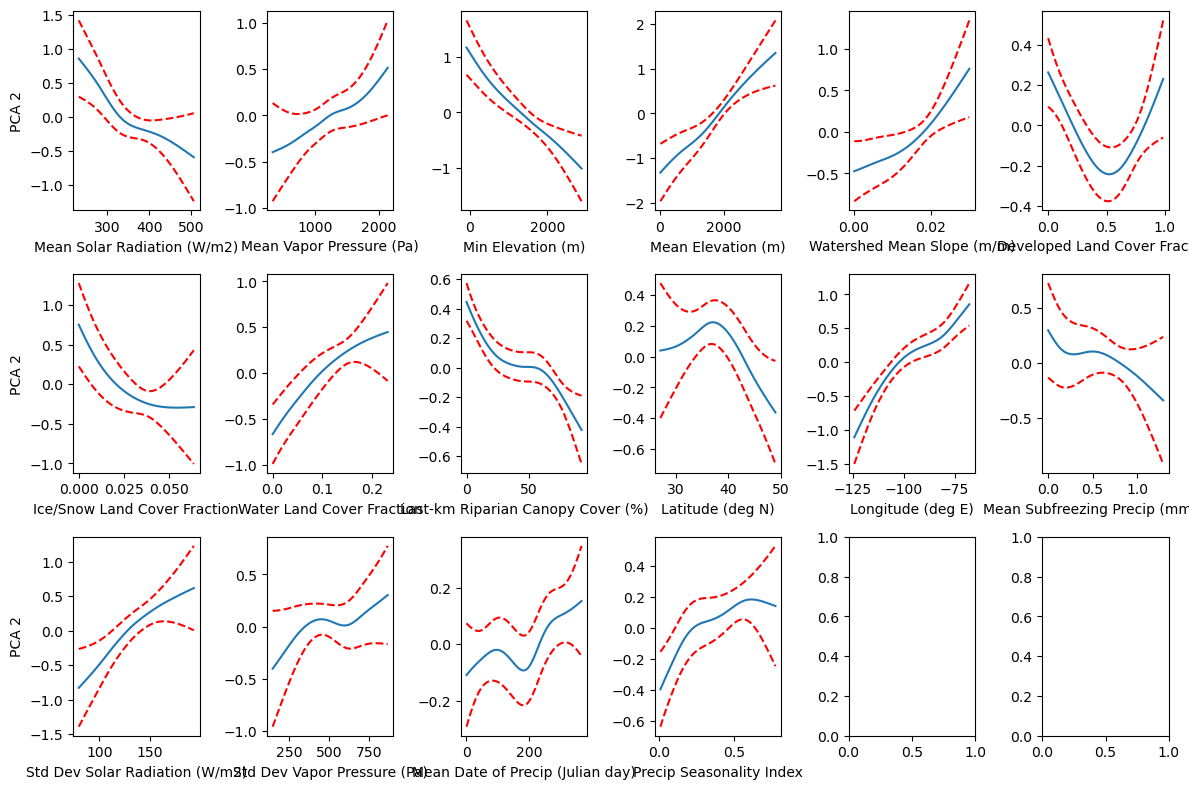

In [359]:
pdps(gam2, False, rename(var2), "PCA 2", "results/PCA_PDPs/GAM2.png")

## PCA3

In [360]:
(var3, lam3, gcv3) = tune_gcv(list(allvar), 10, None, X, Y["pca3"])
print(var3, lam3, gcv3)
eq3 = eqmk(len(var3))
gam3 = LinearGAM(eq3, lam=lam3).fit(X[var3], Y["pca3"])
gam3.summary()

|||Lambda: 300.00 | Dropped: canopy | GCV: 0.6372
|Lambda: 900.00 | Dropped: flowdir | GCV: 0.6329
|Lambda: 300.00 | Dropped: area | GCV: 0.6283
|Lambda: 300.00 | Dropped: slope | GCV: 0.6245
|Lambda: 300.00 | Dropped: forest | GCV: 0.6214
|Lambda: 300.00 | Dropped: vp_sd | GCV: 0.6181
|Lambda: 300.00 | Dropped: tmax_phi | GCV: 0.6154
|Lambda: 300.00 | Dropped: srad | GCV: 0.6137
|Lambda: 300.00 | Dropped: ice_snow | GCV: 0.6123
|Lambda: 300.00 | Dropped: tmax | GCV: 0.6106
|Lambda: 300.00 | Dropped: developed | GCV: 0.6097
|Lambda: 300.00 | Dropped: wetland | GCV: 0.6089
|Lambda: 300.00 | Dropped: frozen | GCV: 0.6087
|Lambda: 300.00 | Dropped: srad_sd | GCV: 0.6079
|Lambda: 300.00 | Dropped: prcp_index | GCV: 0.6075
|['prcp', 'vp', 'elev_min', 'elev', 'water', 'lat', 'lon', 'cold_prcp', 'prcp_sd', 'prcp_phi', 'tmax_index'] 300.0 0.6075149638889441
LinearGAM                                                                                                 
===============================

/tmp/ipykernel_934270/955437856.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam3.summary()


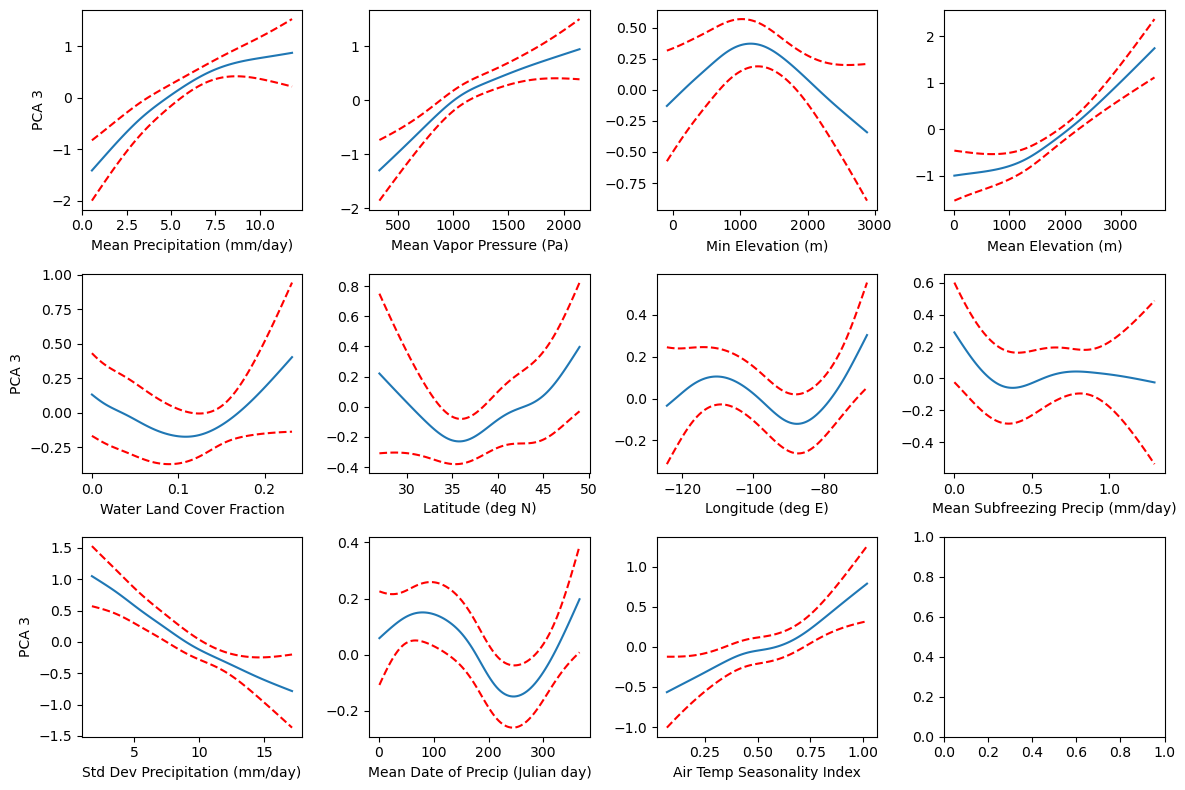

In [361]:
pdps(gam3, False, rename(var3), "PCA 3", "results/PCA_PDPs/GAM3.png")

## PCA4

In [362]:
(var4, lam4, gcv4) = tune_gcv(list(allvar), 10, None, X, Y["pca4"])
print(var4, lam4, gcv4)
eq4 = eqmk(len(var4))
gam4 = LinearGAM(eq4, lam=lam4).fit(X[var4], Y["pca4"])
gam4.summary()

|||Lambda: 300.00 | Dropped: canopy | GCV: 0.4988
|Lambda: 100.00 | Dropped: flowdir | GCV: 0.4932
|Lambda: 100.00 | Dropped: forest | GCV: 0.4897
|Lambda: 100.00 | Dropped: area | GCV: 0.4868
|Lambda: 100.00 | Dropped: tmax_phi | GCV: 0.4841
|Lambda: 100.00 | Dropped: tmax_index | GCV: 0.4821
|Lambda: 100.00 | Dropped: cold_prcp | GCV: 0.4807
|Lambda: 100.00 | Dropped: elev | GCV: 0.4796
|Lambda: 100.00 | Dropped: srad | GCV: 0.4792
|Lambda: 100.00 | Dropped: prcp_phi | GCV: 0.4784
|['tmax', 'prcp', 'vp', 'elev_min', 'slope', 'wetland', 'developed', 'ice_snow', 'water', 'lat', 'lon', 'frozen', 'prcp_sd', 'srad_sd', 'vp_sd', 'prcp_index'] 100.0 0.4784482381985723
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      55.305
Link Fu

/tmp/ipykernel_934270/2958379228.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam4.summary()


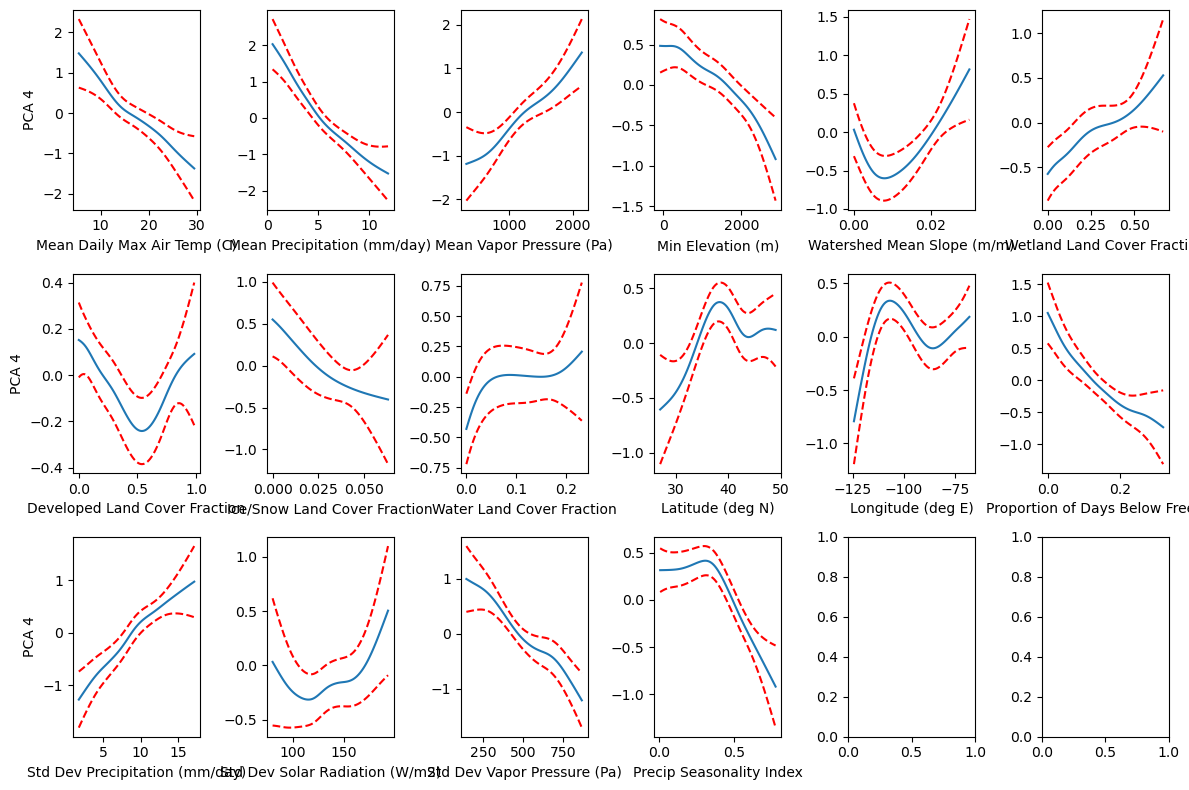

In [364]:
pdps(gam4, False, rename(var4), "PCA 4", "results/PCA_PDPs/GAM4.png")

## PCA5

In [365]:
(var5, lam5, gcv5) = tune_gcv(list(allvar), 10, None, X, Y["pca5"])
print(var5, lam5, gcv5)
eq5 = eqmk(len(var5))
gam5 = LinearGAM(eq5, lam=lam5).fit(X[var5], Y["pca5"])
gam5.summary()

|||Lambda: 300.00 | Dropped: canopy | GCV: 0.3959
|Lambda: 900.00 | Dropped: flowdir | GCV: 0.3940
|Lambda: 300.00 | Dropped: cold_prcp | GCV: 0.3914
|Lambda: 300.00 | Dropped: slope | GCV: 0.3897
|Lambda: 300.00 | Dropped: ice_snow | GCV: 0.3881
|Lambda: 300.00 | Dropped: water | GCV: 0.3869
|Lambda: 300.00 | Dropped: area | GCV: 0.3857
|Lambda: 300.00 | Dropped: developed | GCV: 0.3847
|Lambda: 300.00 | Dropped: forest | GCV: 0.3828
|Lambda: 300.00 | Dropped: wetland | GCV: 0.3818
|Lambda: 300.00 | Dropped: tmax | GCV: 0.3814
|Lambda: 300.00 | Dropped: elev_min | GCV: 0.3811
|Lambda: 100.00 | Dropped: frozen | GCV: 0.3810
|['prcp', 'srad', 'vp', 'elev', 'lat', 'lon', 'prcp_sd', 'srad_sd', 'vp_sd', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'] 100.0 0.380988114736364
LinearGAM                                                                                                 
=============================================== ==========================================================
D

/tmp/ipykernel_934270/2043683337.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam5.summary()


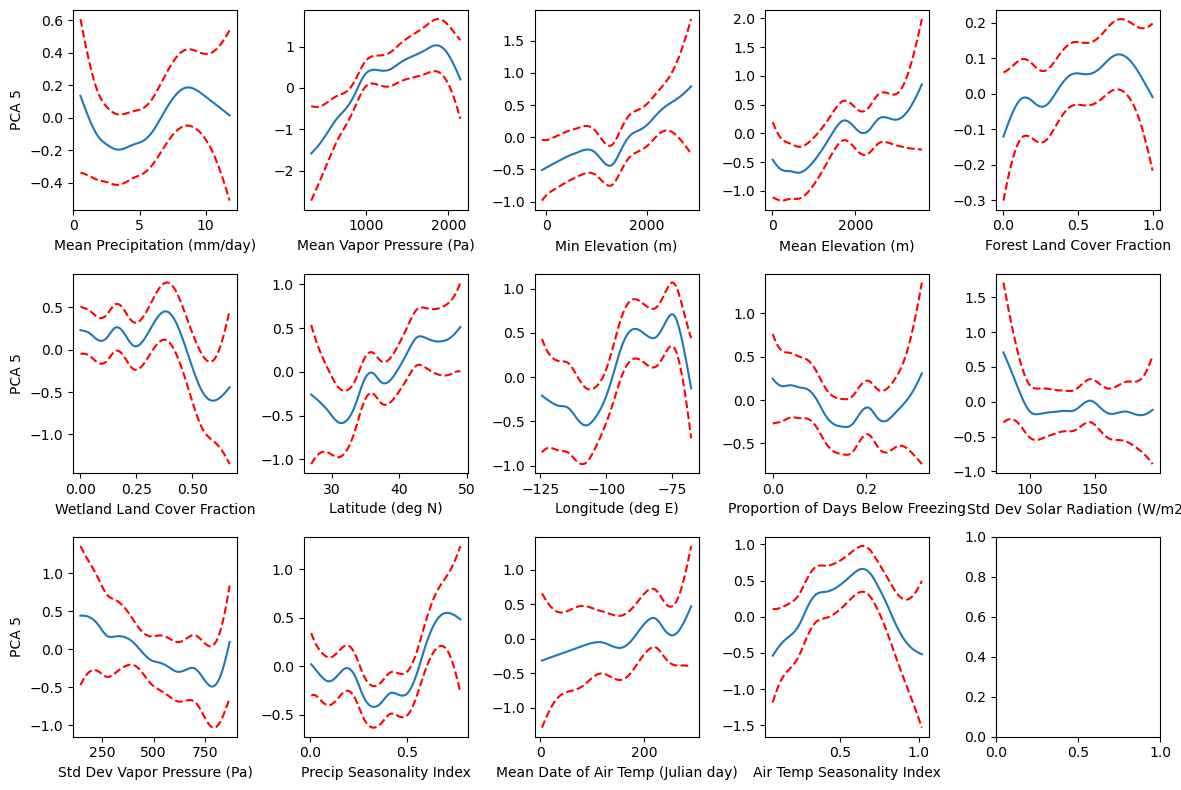

In [342]:
pdps(gam5, False, rename(var5), "PCA 5", "results/PCA_PDPs/GAM5.png")

## PCA6

In [ ]:
(var6, lam6, gcv6) = tune_gcv(list(allvar), 10, None, X, Y["pca6"])
print(var6, lam6, gcv6)
eq6 = eqmk(len(var6))
gam6 = LinearGAM(eq6, lam=lam6).fit(X[var6], Y["pca6"])
gam6.summary()

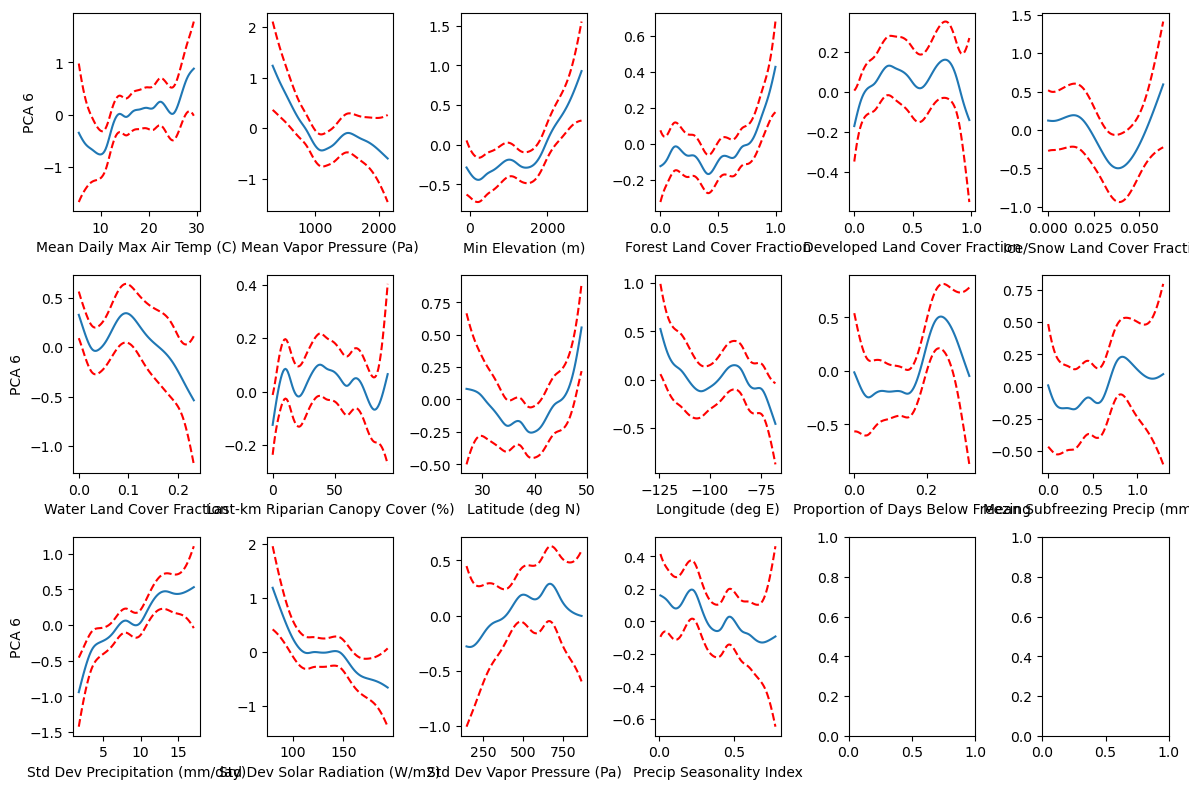

In [387]:
pdps(gam6, False, rename(var6), "PCA 6", "results/PCA_PDPs/GAM6.png")

## PCA7

In [ ]:
(var7, lam7, gcv7) = tune_gcv(list(allvar), 10, None, X, Y["pca7"])
print(var7, lam7, gcv7)
eq7 = eqmk(len(var7))
gam7 = LinearGAM(eq7, lam=lam7).fit(X[var7], Y["pca7"])
gam7.summary()

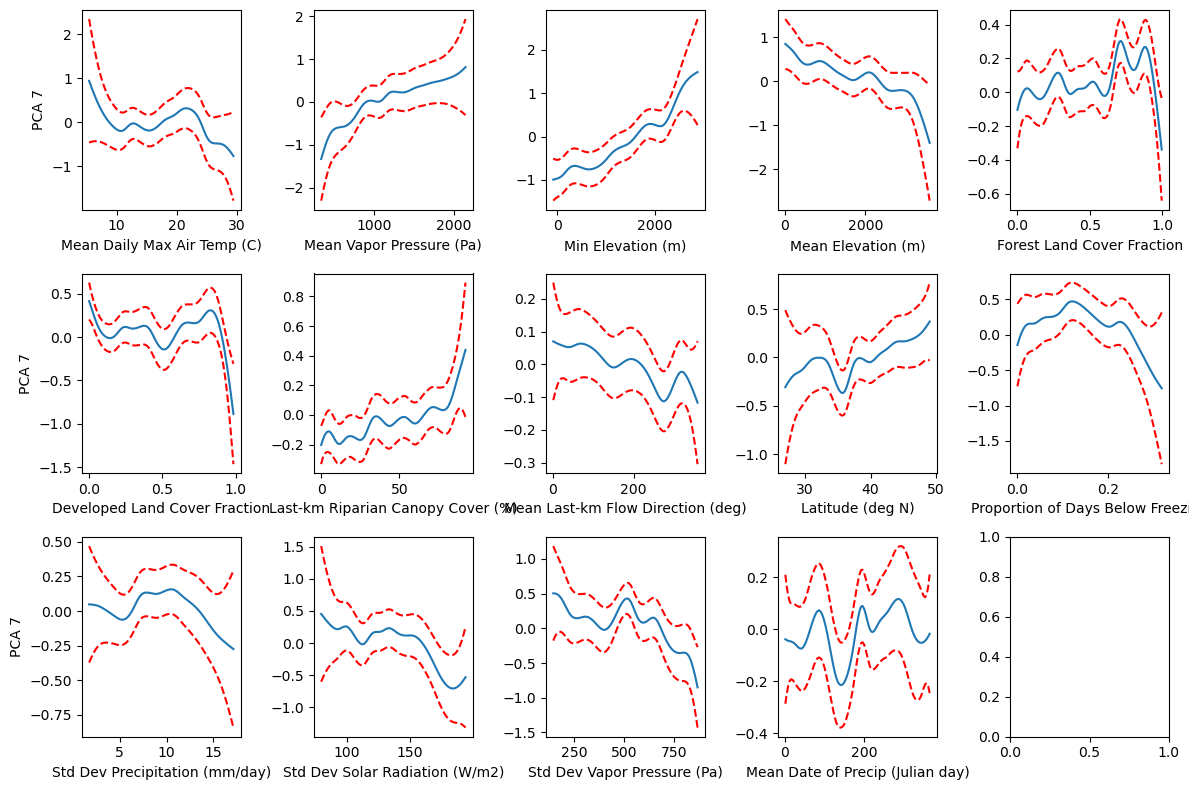

In [435]:
pdps(gam7, False, rename(var7), "PCA 7", "results/PCA_PDPs/GAM7.png")

## PCA8

In [ ]:
(var8, lam8, gcv8) = tune_gcv(list(allvar), 10, None, X, Y["pca8"])
print(var8, lam8, gcv8)
eq8 = eqmk(len(var8))
gam8 = LinearGAM(eq8, lam=lam8).fit(X[var8], Y["pca8"])
gam8.summary()

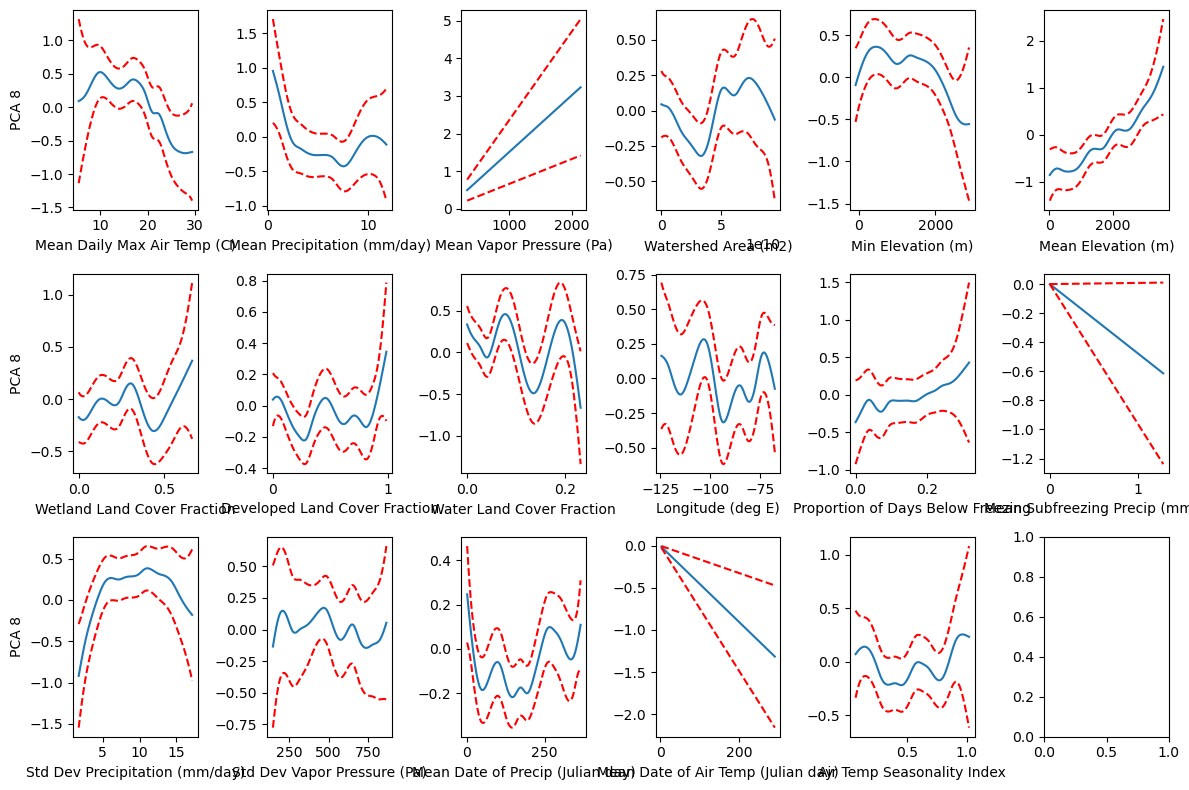

In [482]:
pdps(gam8, False, rename(var8), "PCA 8", "results/PCA_PDPs/GAM8.png")

## Plot GAMs By XVar

/tmp/ipykernel_557272/1340702020.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(nrow, ncol, figsize=(12, 8))


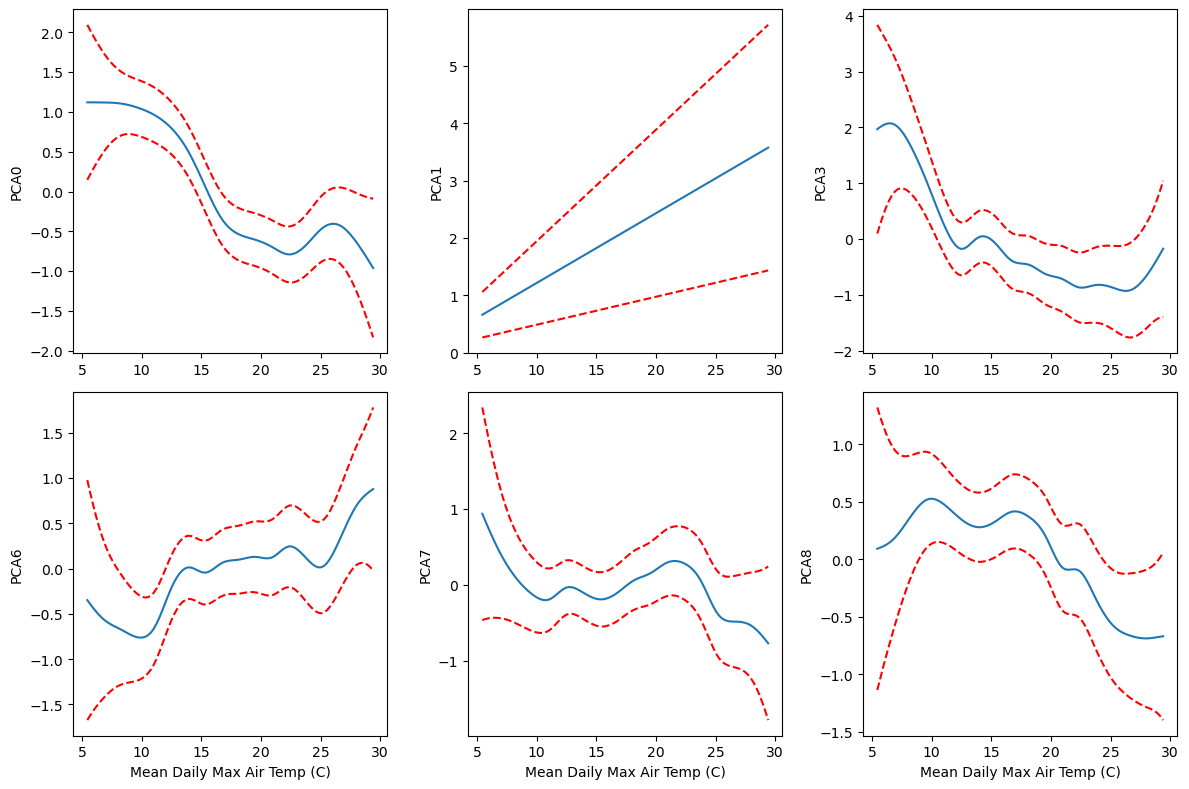

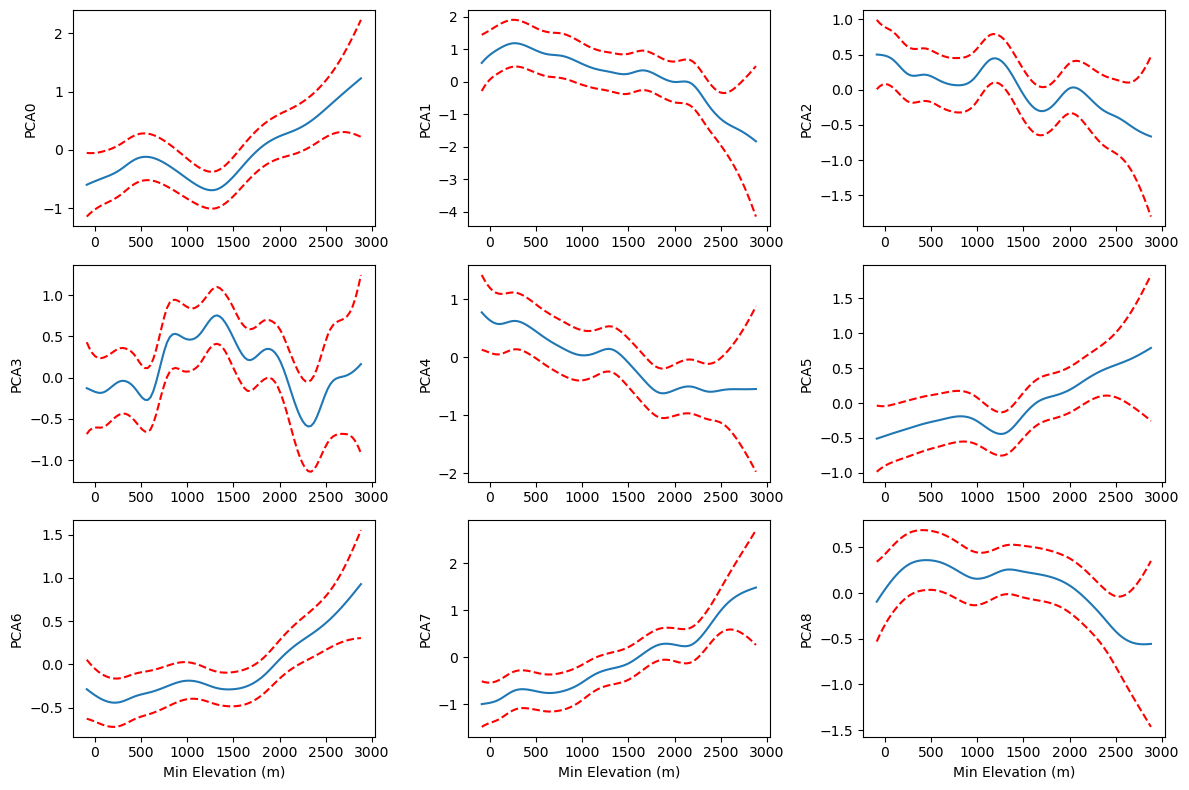

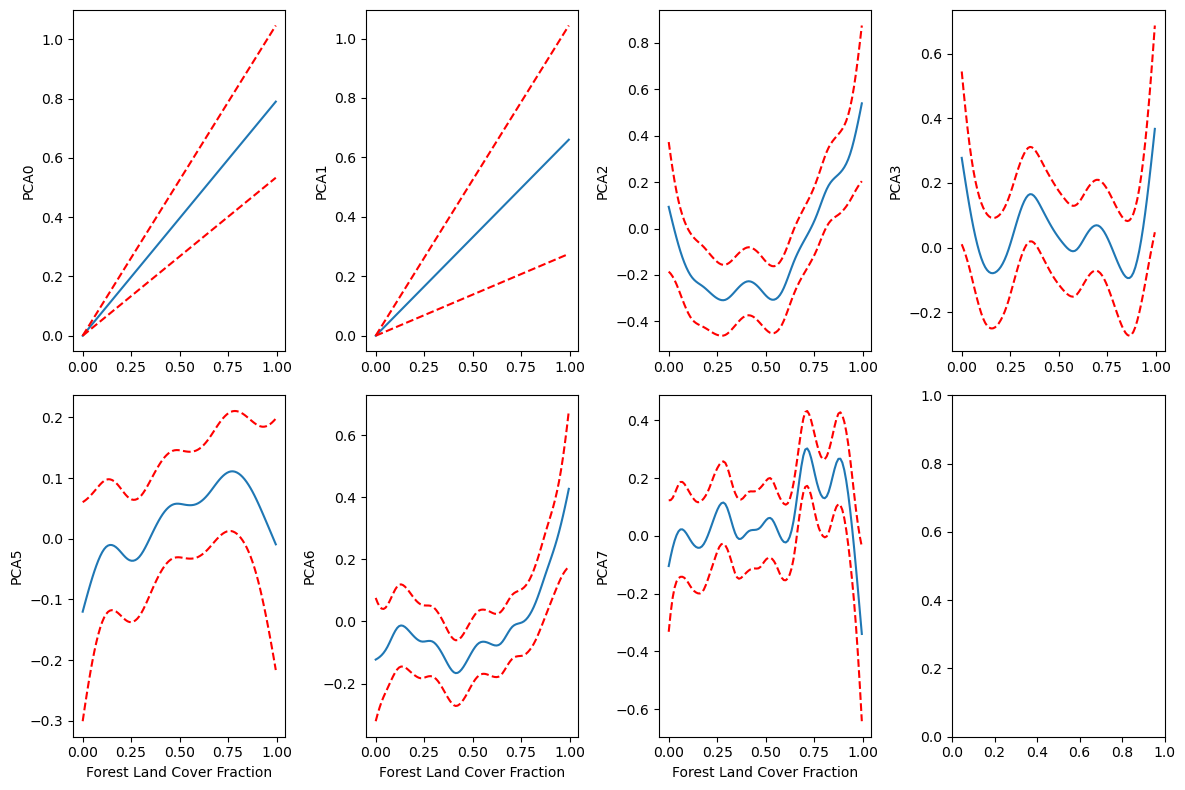

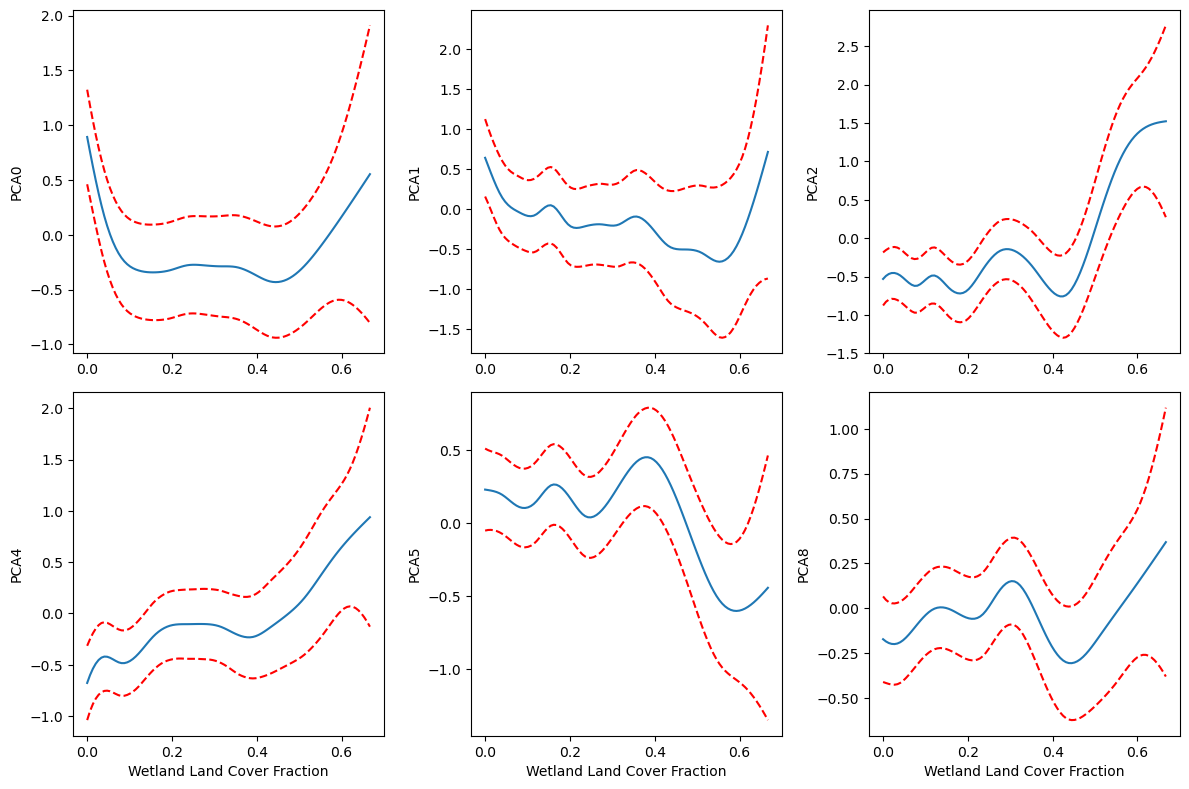

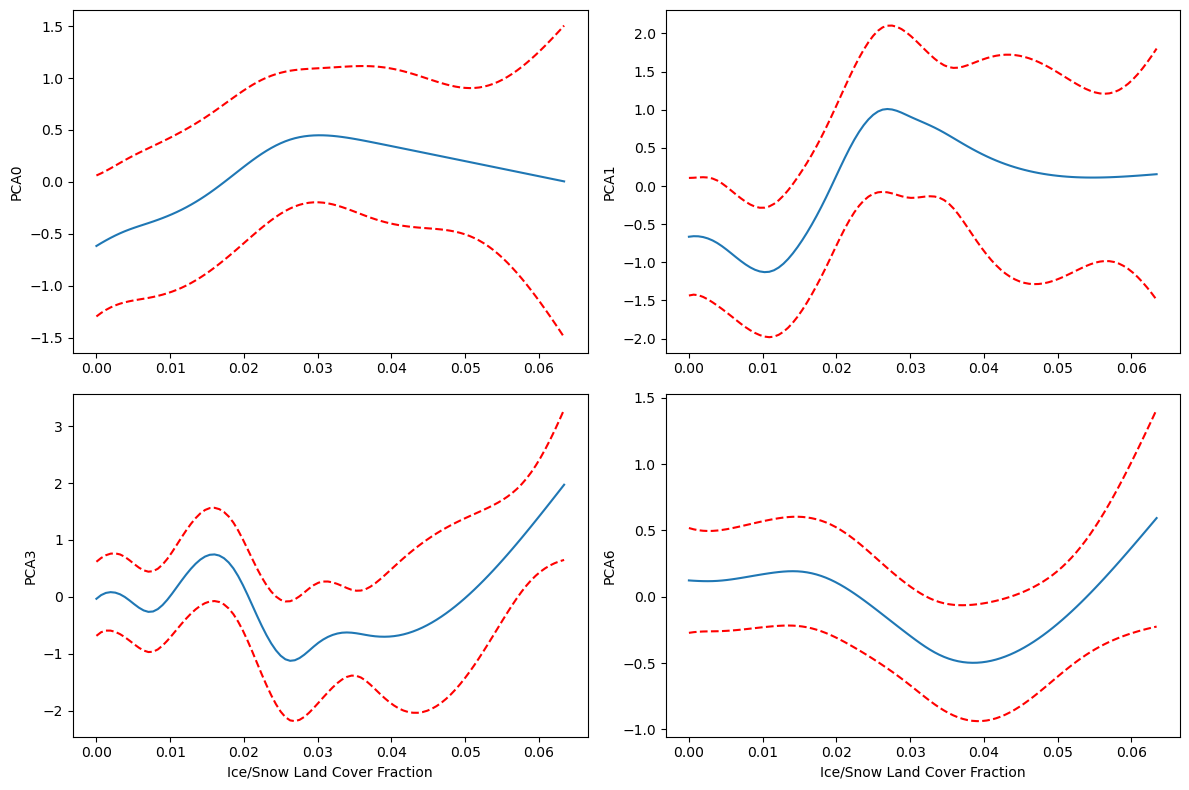

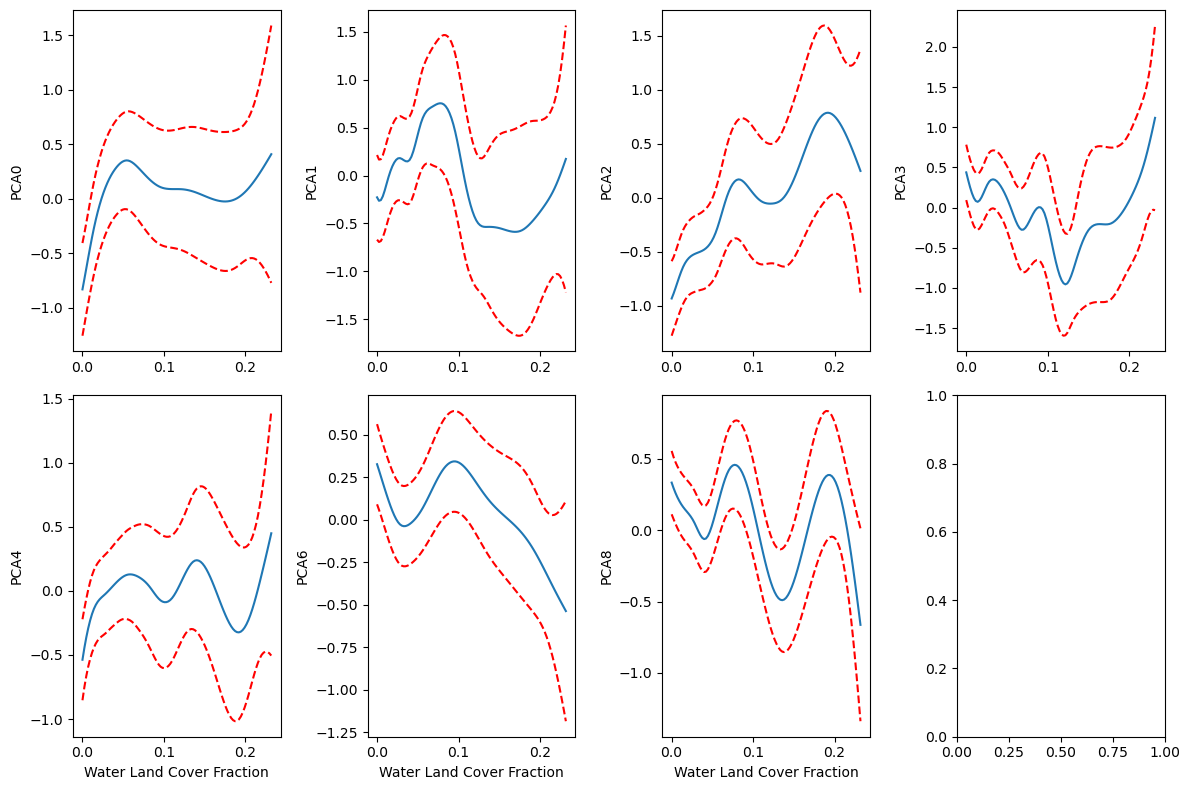

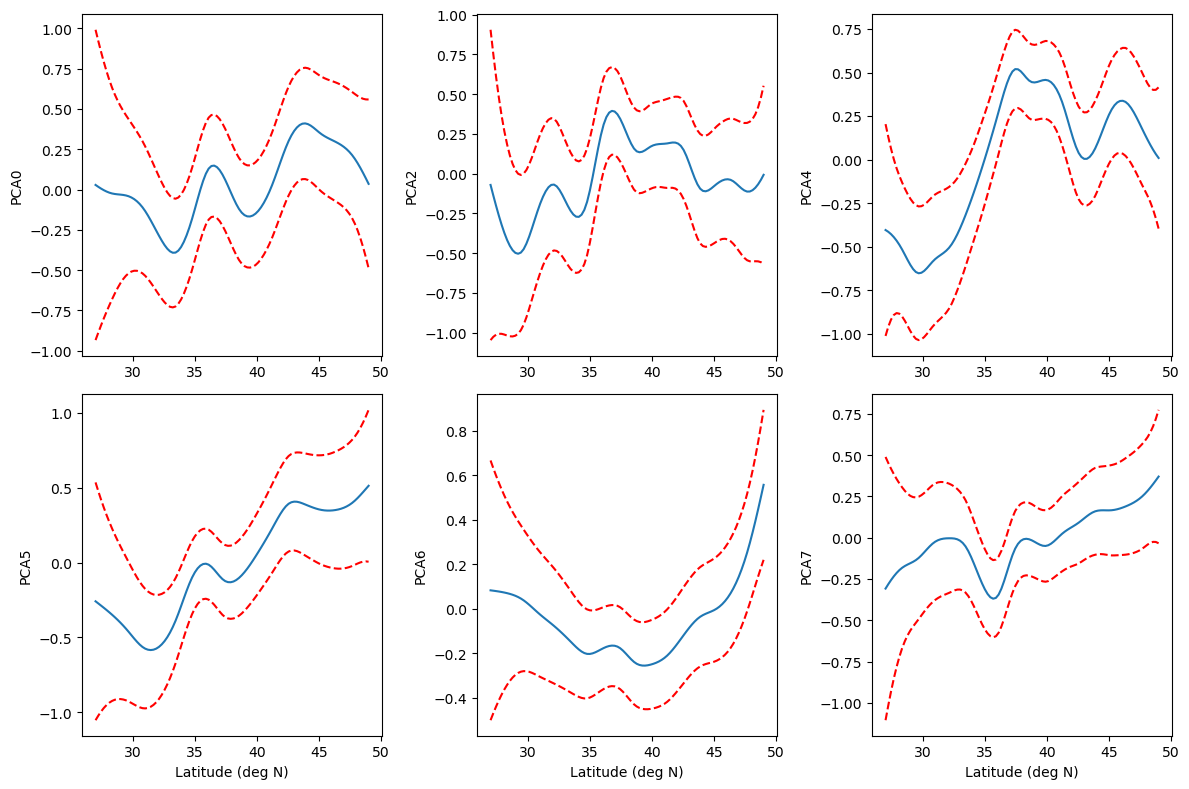

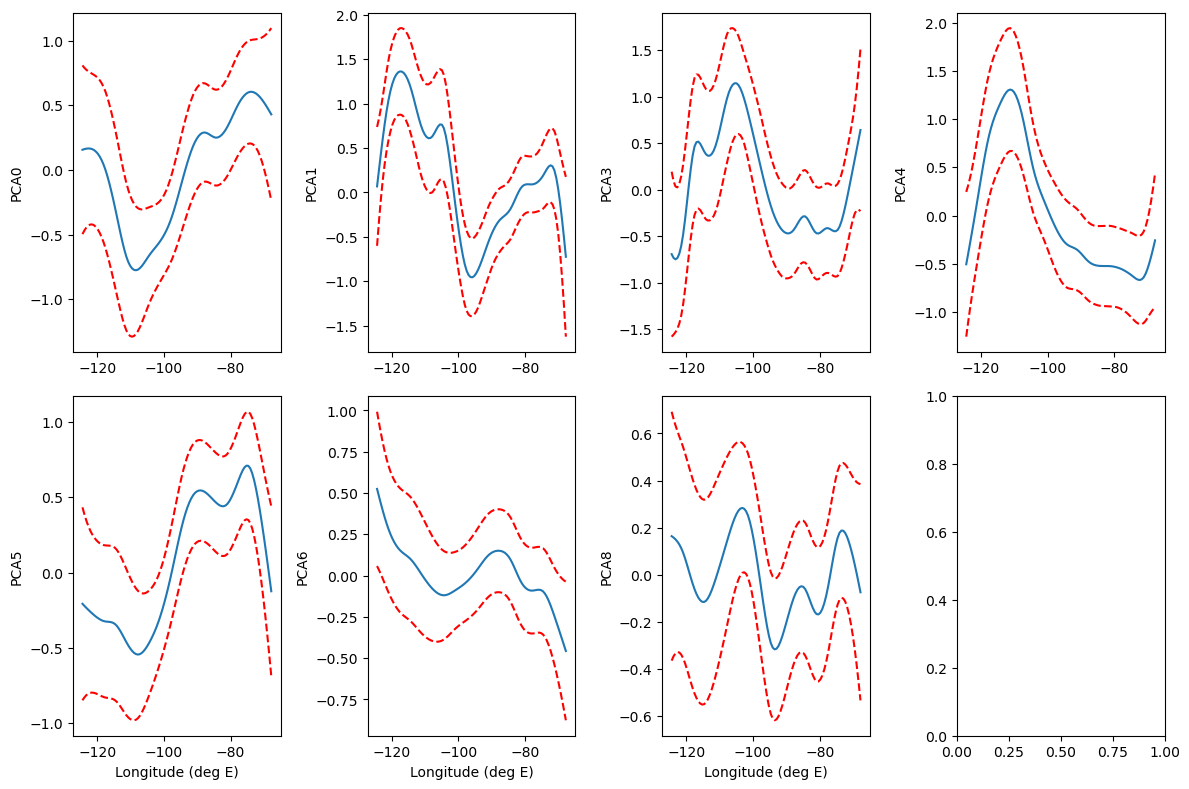

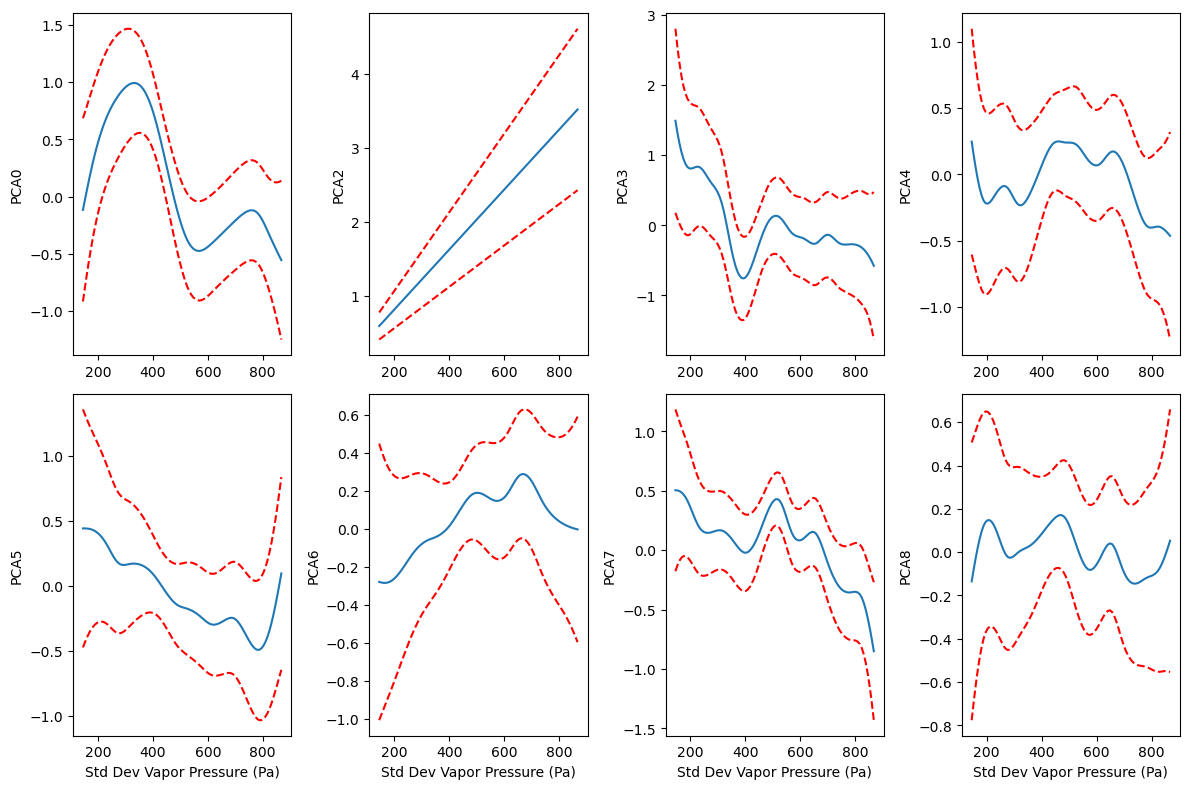

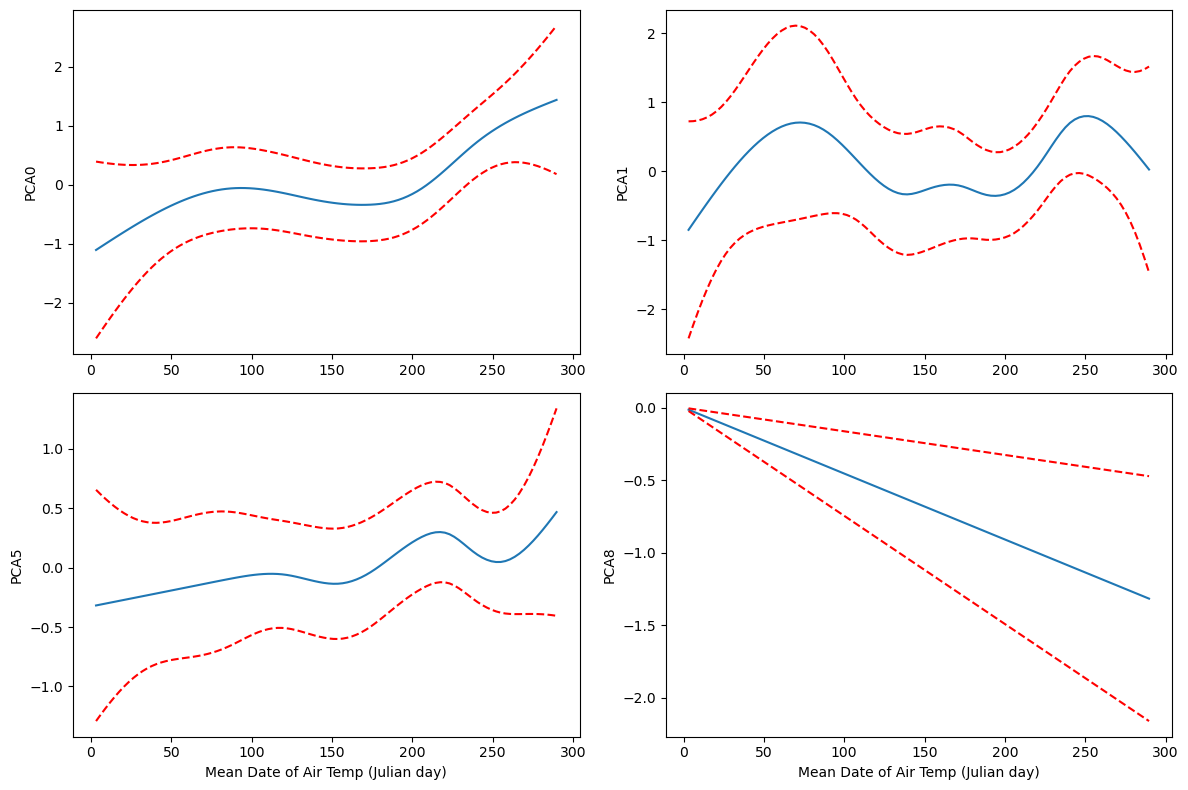

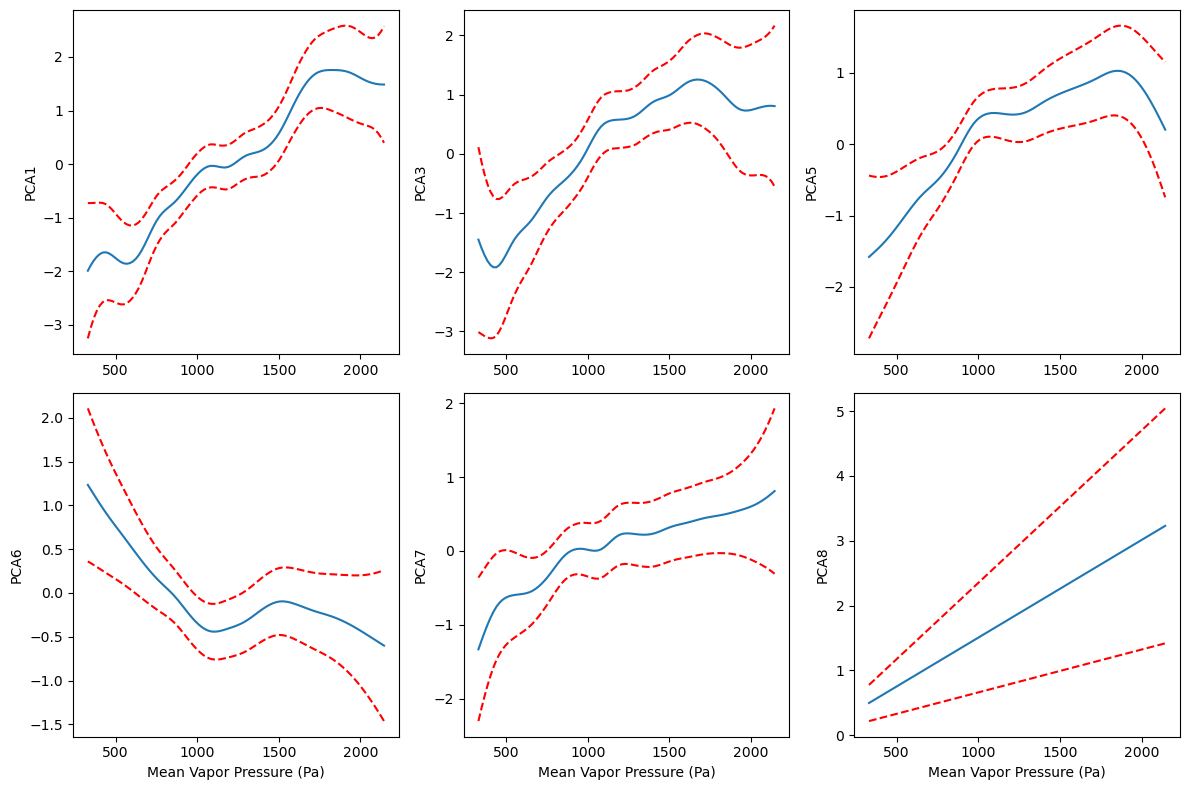

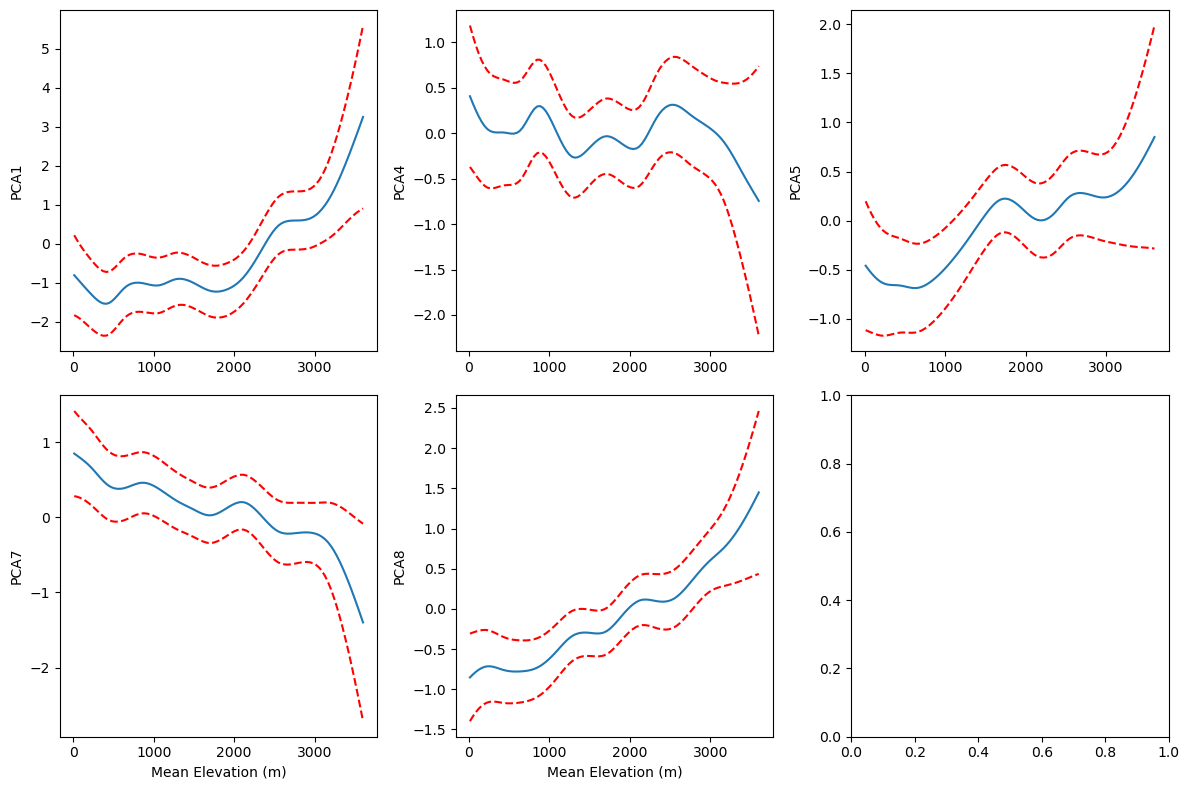

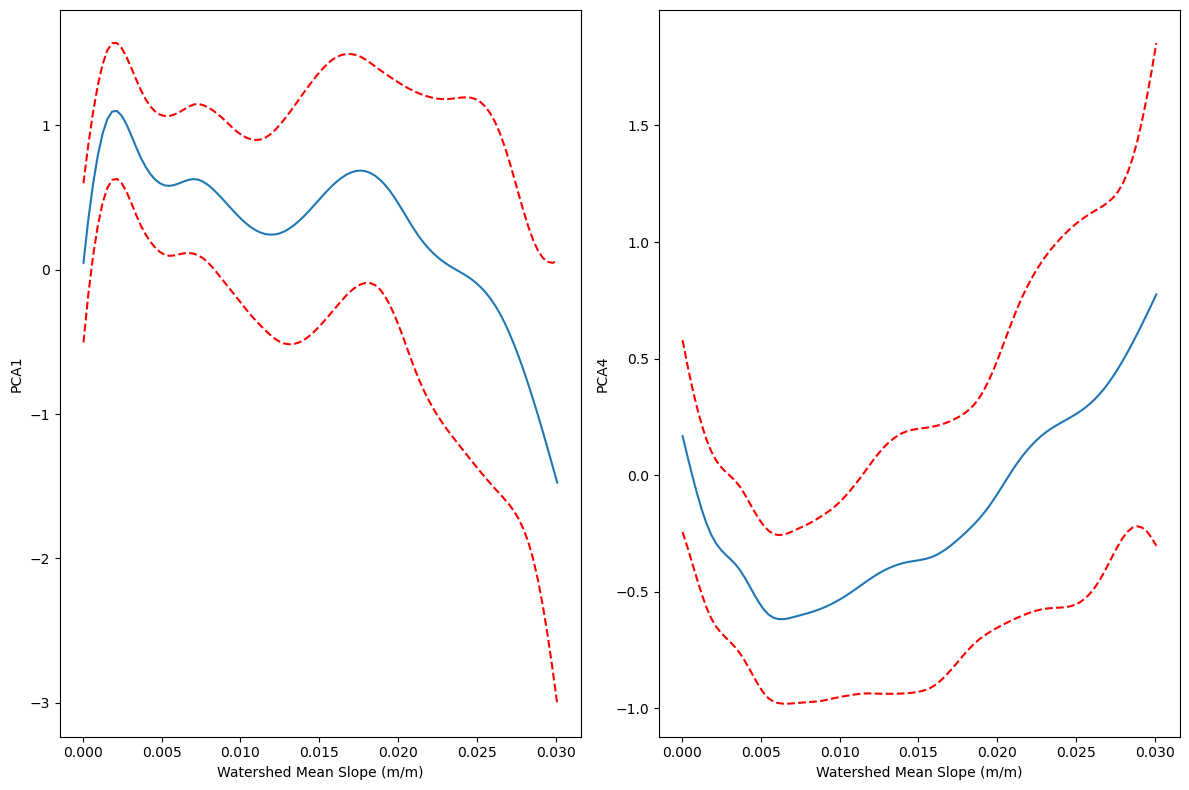

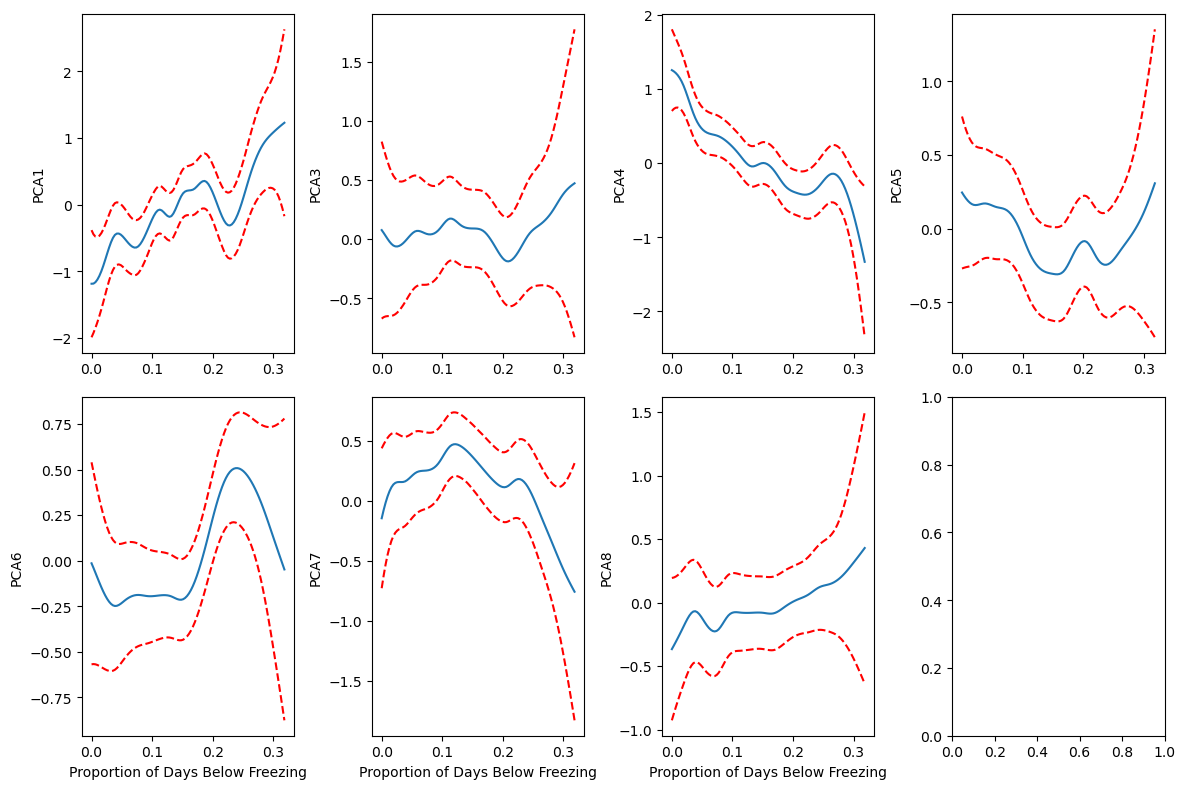

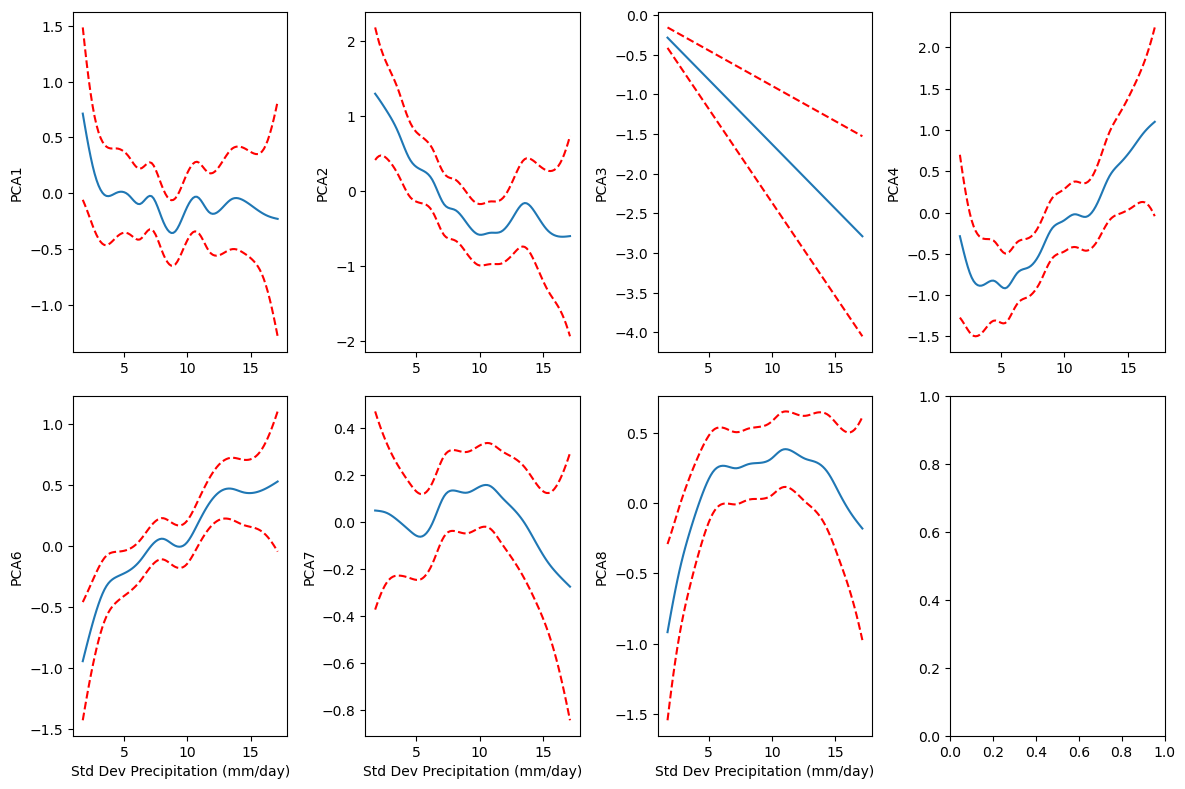

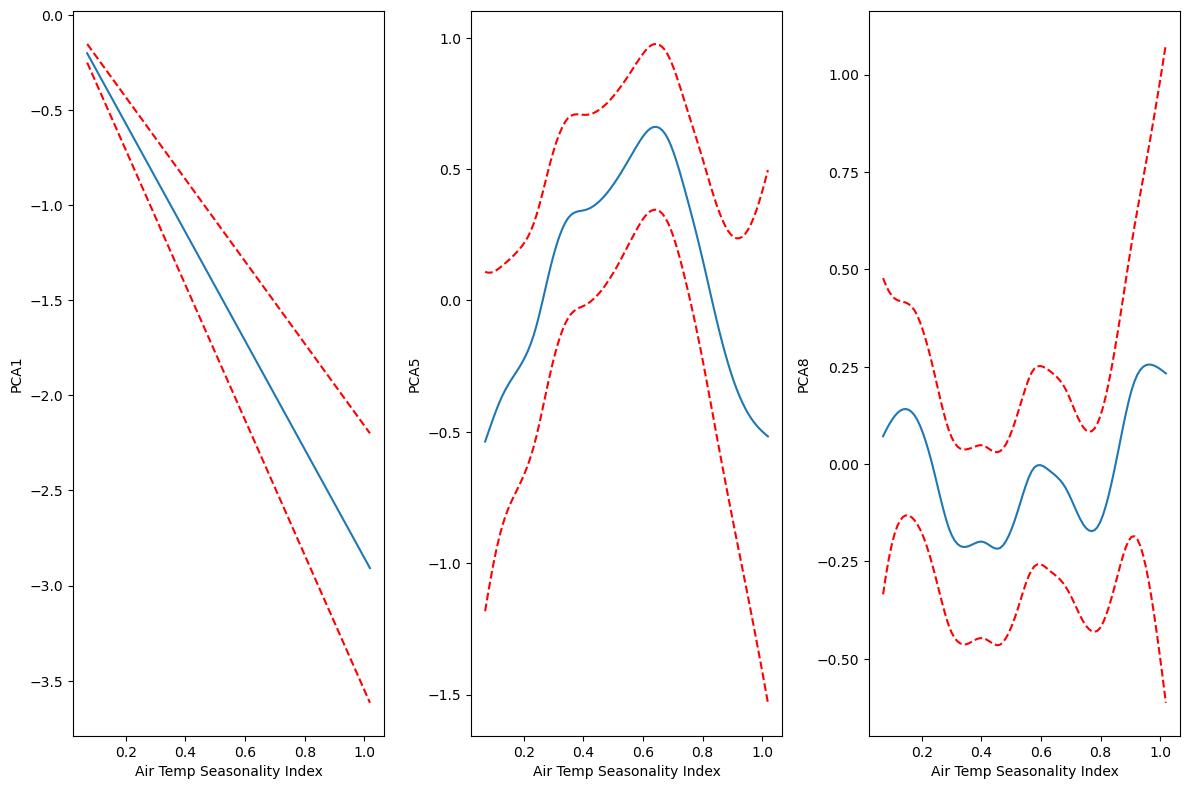

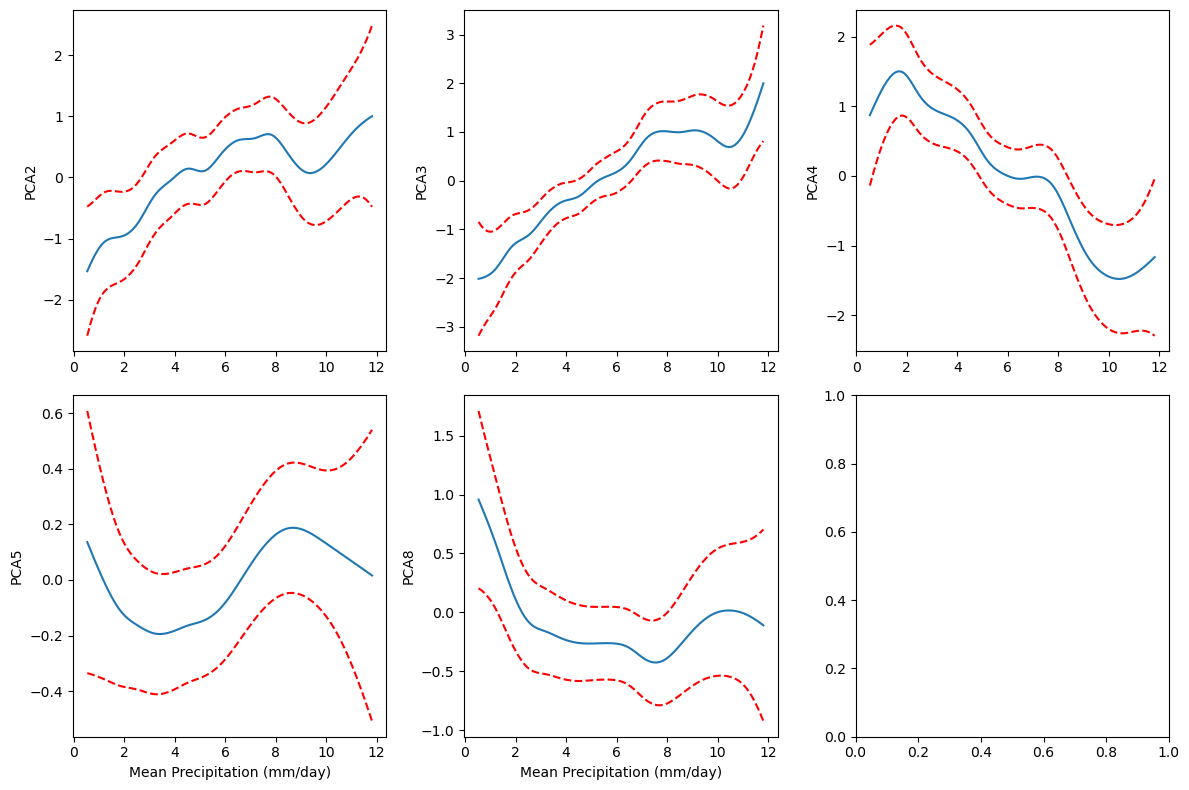

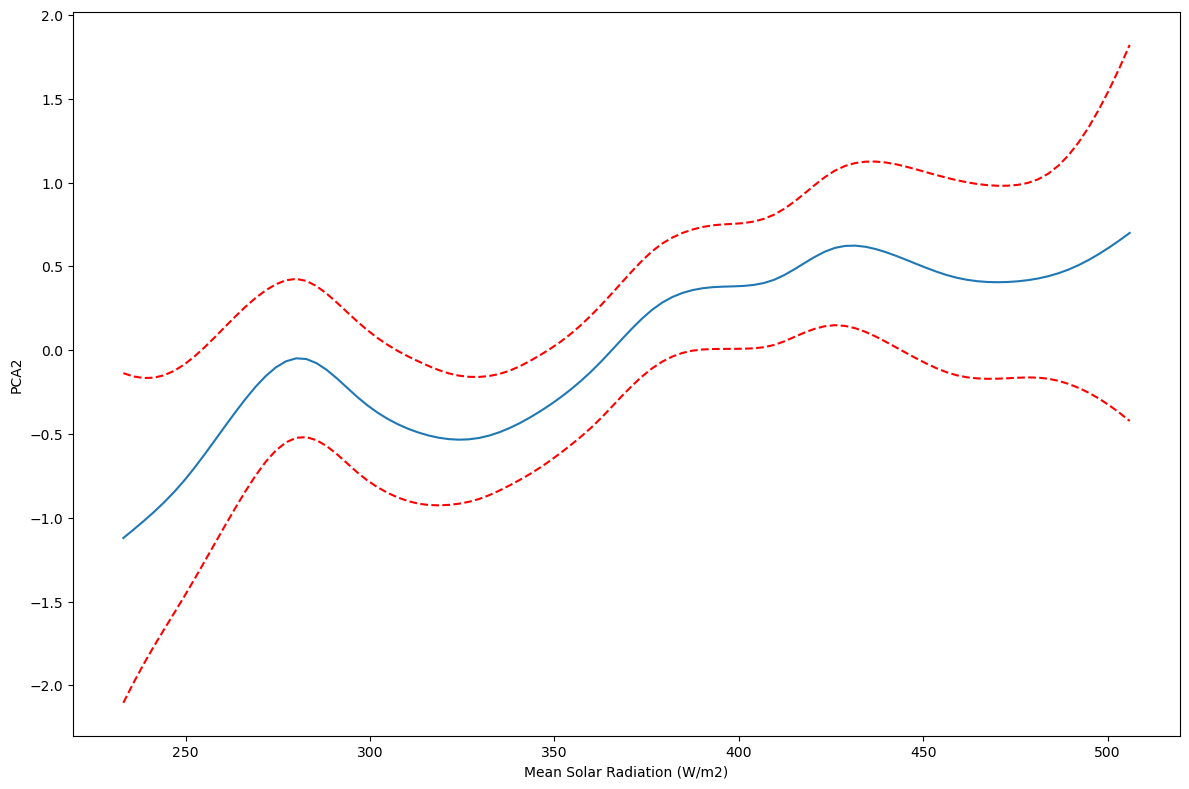

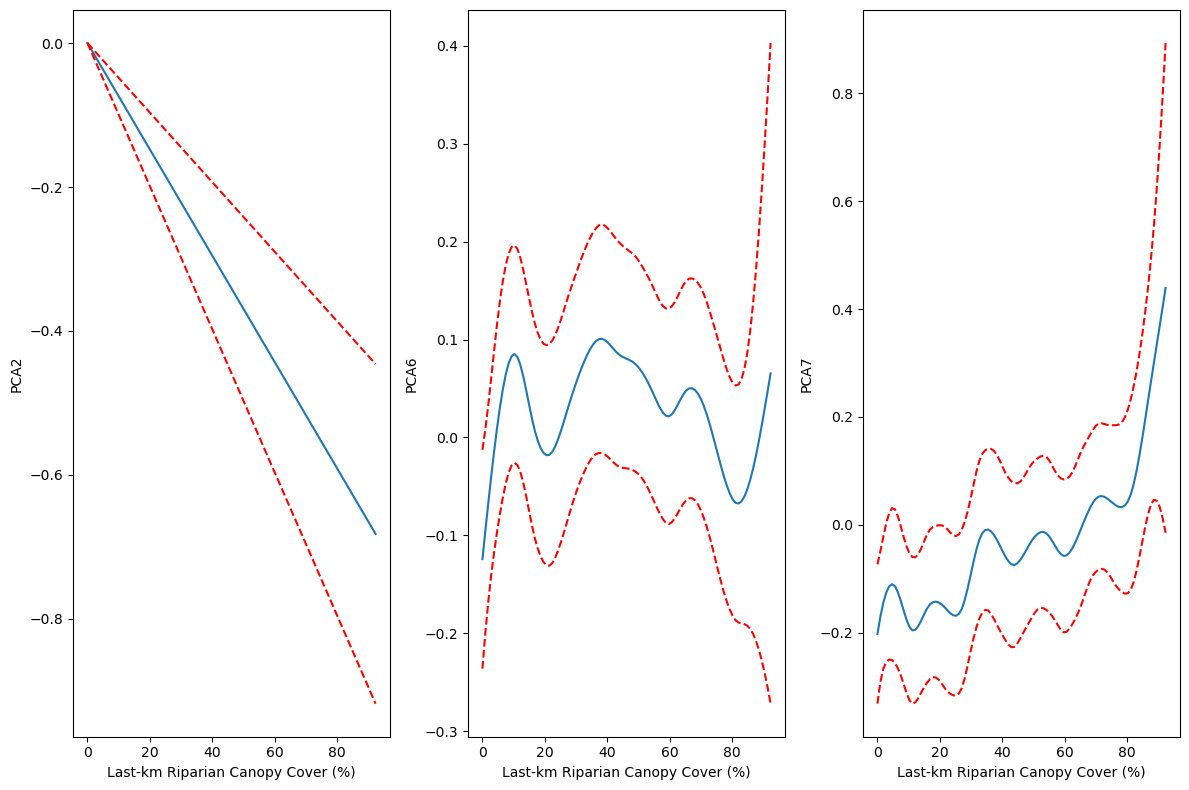

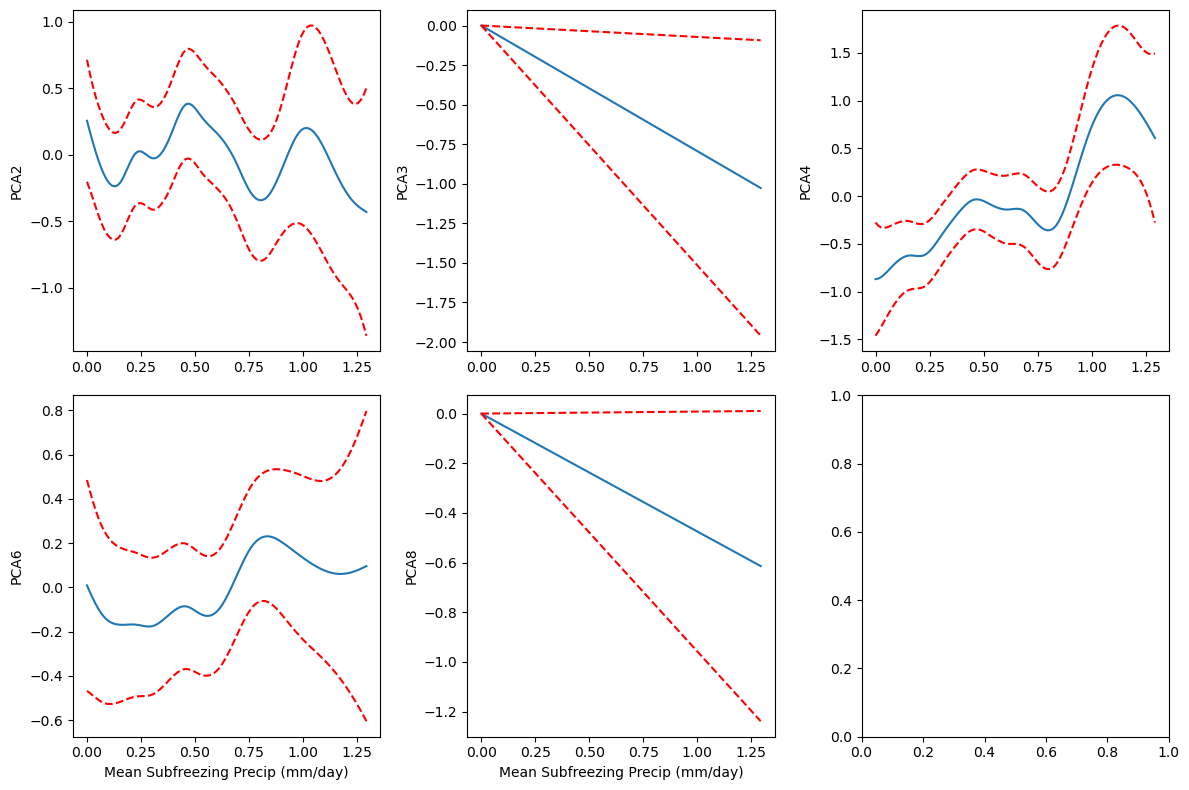

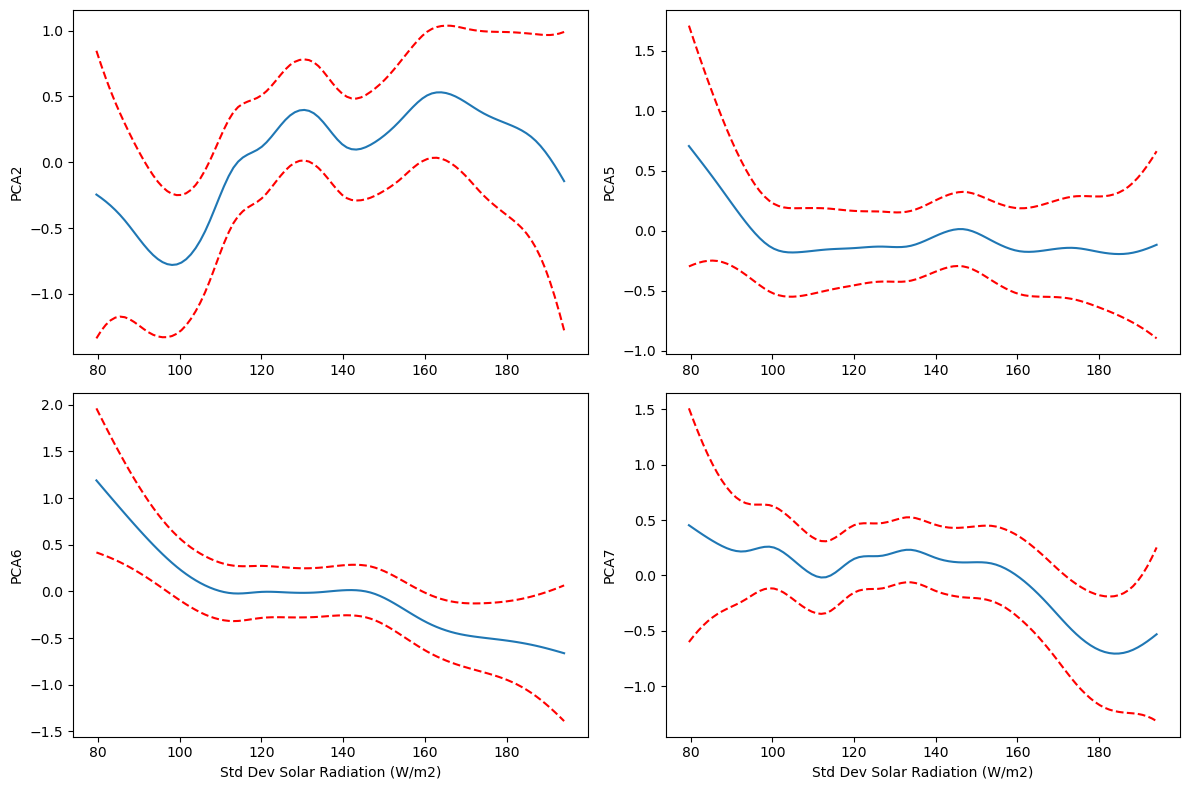

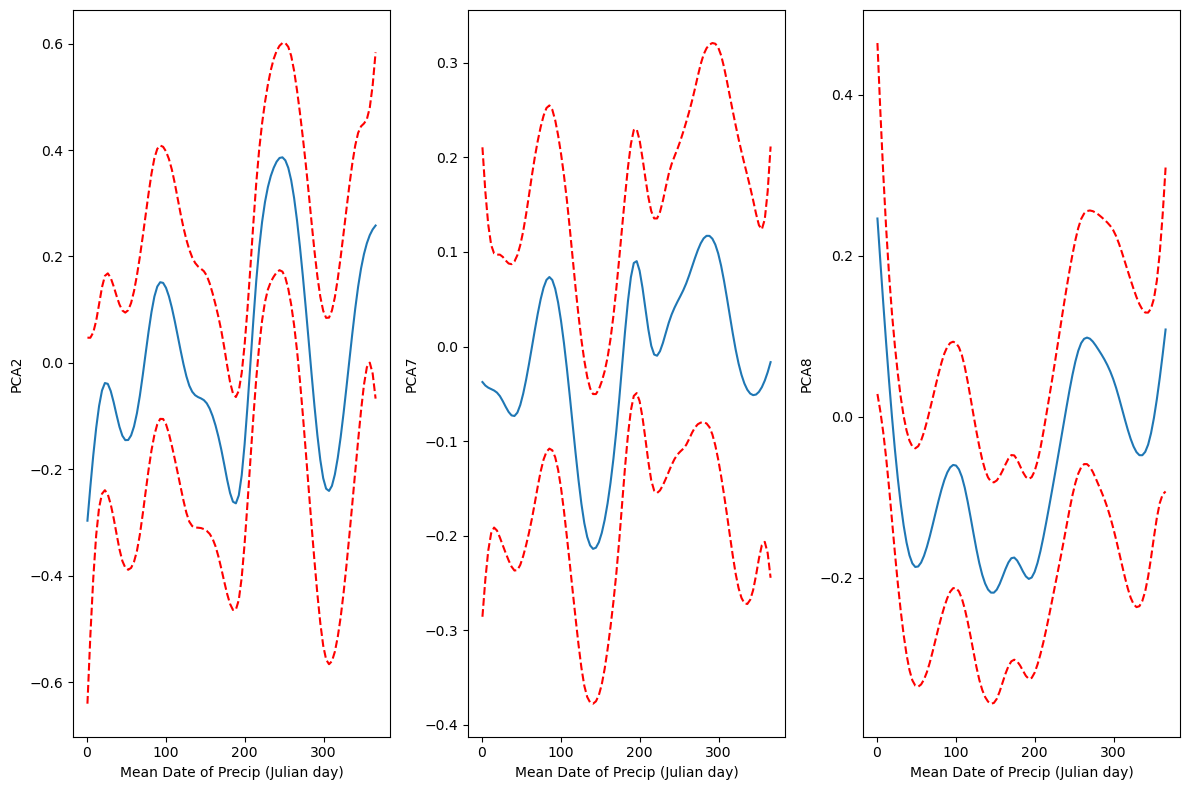

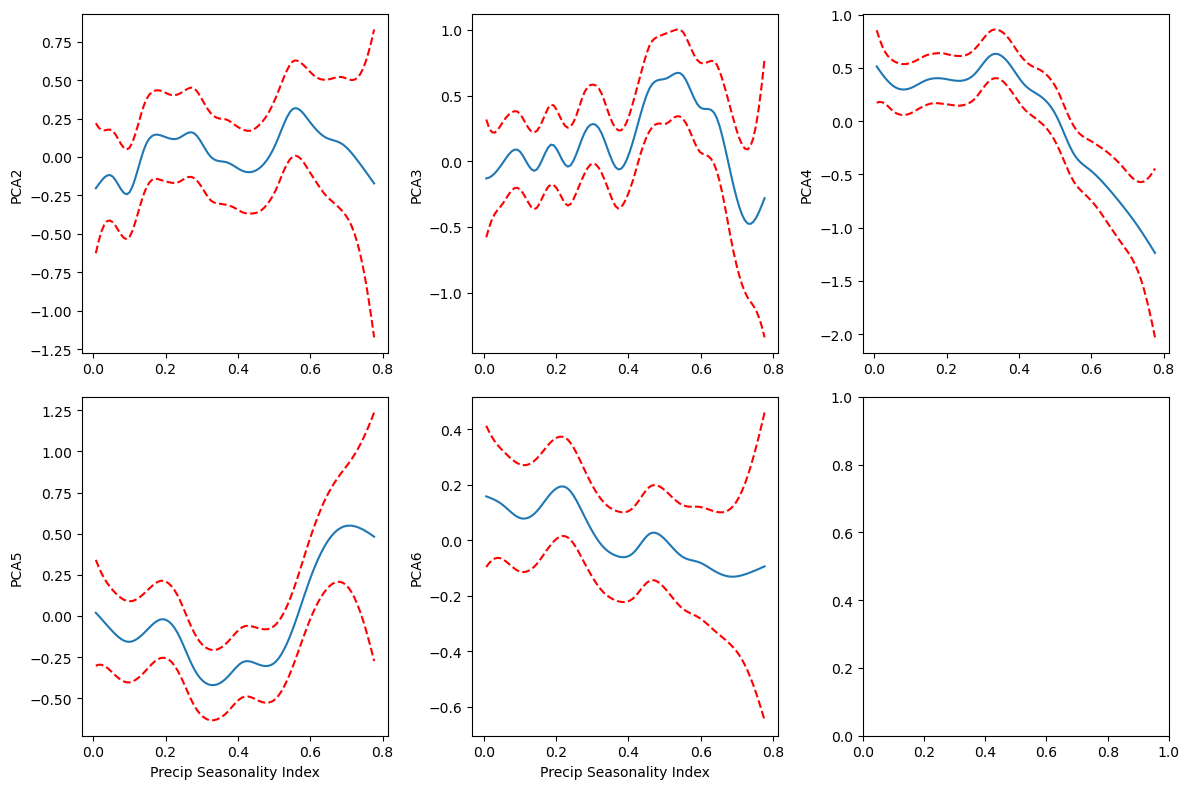

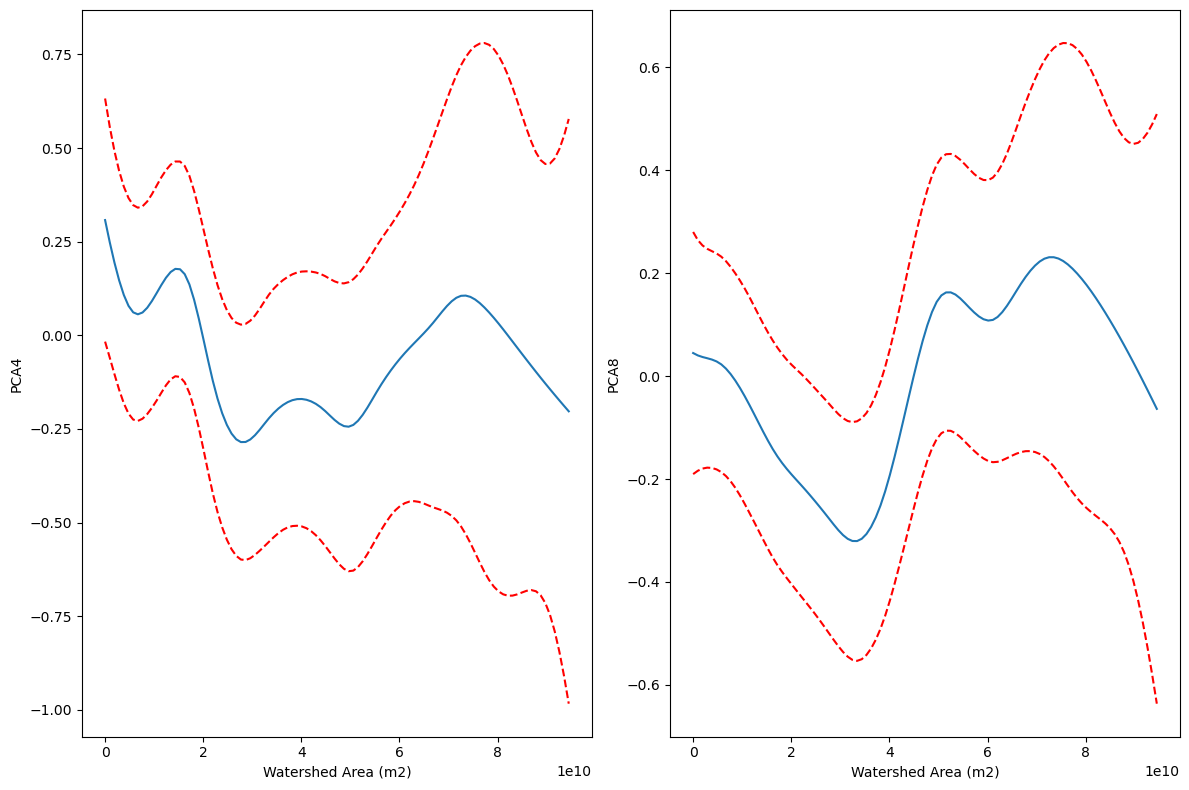

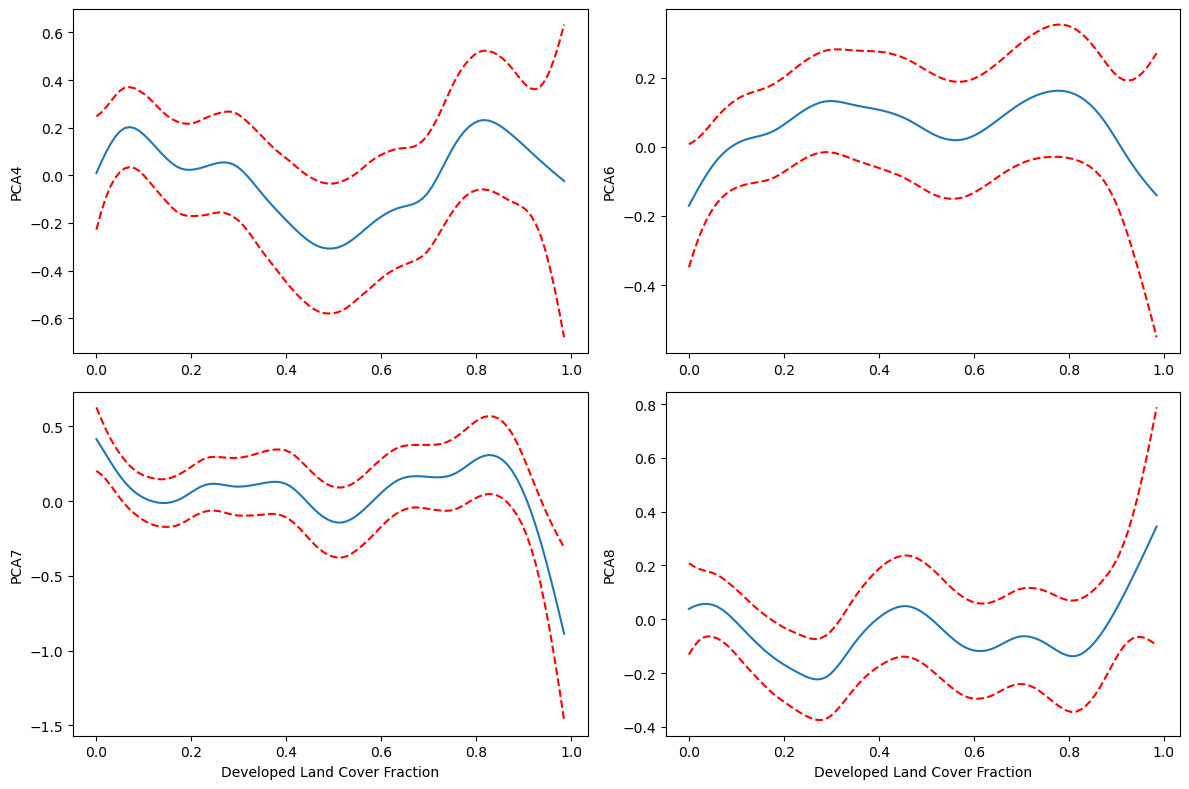

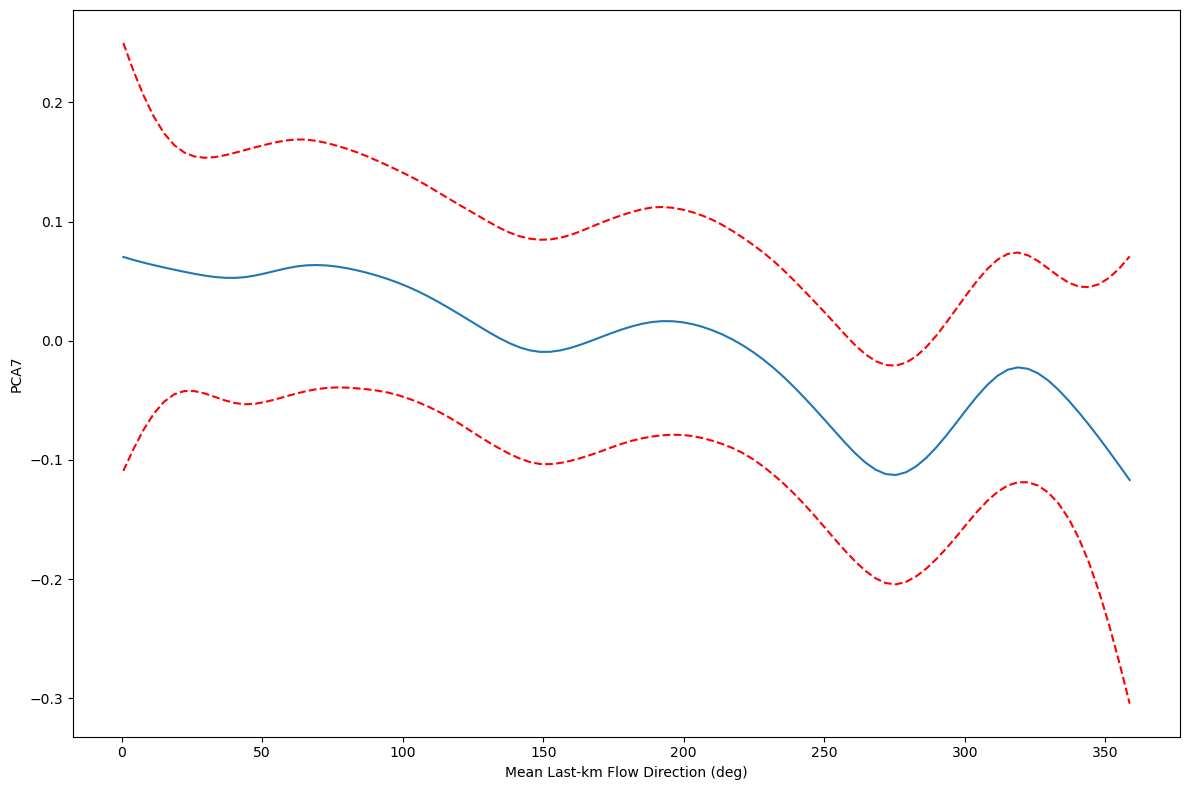

In [484]:
# (gam, xnames, simple_xnames, yname)
savebase = bp + "results/PCA_PDPs/PDPbyX_"
allgams = [
    (gam0, rename(var0), var0, "PCA0"),
    (gam1, rename(var1), var1, "PCA1"),
    (gam2, rename(var2), var2, "PCA2"),
    (gam3, rename(var3), var3, "PCA3"),
    (gam4, rename(var4), var4, "PCA4"),
    (gam5, rename(var5), var5, "PCA5"),
    (gam6, rename(var6), var6, "PCA6"),
    (gam7, rename(var7), var7, "PCA7"),
    (gam8, rename(var8), var8, "PCA8")
]
pdps_by_x(allgams, savebase)

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  Export the GAM setups and hop over to the validation notebook.

## New GAMs

In [483]:
# Run this to build list...
print("var_sets = [")
# for (vr, nm) in [("itx", "Intercept"), ("amp", "Amplitude"), ("ssu", "SpringSummer"),
#                  ("fw", "FallWinter"), ("spd", "SpringDay"), ("sud", "SummerDay"),
#                  ("fad", "FallDay"), ("wid", "WinterDay"),
#                  # ("atc", "at_coef")
#                  ("tcmax", "threshold_coef_max"), ("tcmin", "threshold_coef_min"), ("tcc", "threshold_act_cutoff")
#                 ]:
for pca in range(9):
    vr = str(pca)
    nm = "PCA" + vr
    vrs = eval("var" + vr)
    eq = eval("eq" + vr)
    lam = eval("lam" + vr)
    print(f'    {{"name": "{nm}", "vars": {vrs}, "eq": {eq}, "lam": {lam}}},')
    # print(f"var_{vr} = {eval('var_' + vr)}")
    # print(f"eq_{vr} = {eval('eq_' + vr)}")
    # print(f"lam_{vr} = {eval('lam_' + vr)}")
print("]")

var_sets = [
    {"name": "PCA0", "vars": ['tmax', 'elev_min', 'forest', 'wetland', 'ice_snow', 'water', 'lat', 'lon', 'vp_sd', 'tmax_phi'], "eq": s(0) + s(1) + l(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 10},
    {"name": "PCA1", "vars": ['tmax', 'vp', 'elev_min', 'elev', 'slope', 'forest', 'wetland', 'ice_snow', 'water', 'lon', 'frozen', 'prcp_sd', 'tmax_phi', 'tmax_index'], "eq": l(0) + s(1) + s(2) + s(3) + s(4) + l(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + l(13), "lam": 0.6},
    {"name": "PCA2", "vars": ['prcp', 'srad', 'elev_min', 'forest', 'wetland', 'water', 'canopy', 'lat', 'cold_prcp', 'prcp_sd', 'srad_sd', 'vp_sd', 'prcp_phi', 'prcp_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + l(6) + s(7) + s(8) + s(9) + s(10) + l(11) + s(12) + s(13), "lam": 1},
    {"name": "PCA3", "vars": ['tmax', 'prcp', 'vp', 'elev_min', 'ice_snow', 'water', 'forest', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'vp_sd', 'prcp_index'], "eq": s(0) + s(1) + s(2) + s

In [299]:
var_sets = [
    {"name": "PCA0", "vars": ['tmax', 'elev', 'forest', 'wetland', 'water', 'cold_prcp', 'vp_sd', 'tmax_phi'], "eq": s(0) + s(1) + l(2) + s(3) + s(4) + l(5) + s(6) + l(7), "lam": 3},
    {"name": "PCA1", "vars": ['srad', 'vp', 'elev_min', 'elev', 'slope', 'forest', 'wetland', 'ice_snow', 'water', 'frozen', 'prcp_sd', 'vp_sd', 'tmax_phi', 'tmax_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + l(5) + s(6) + s(7) + s(8) + s(9) + l(10) + l(11) + s(12) + l(13), "lam": 3},
    {"name": "PCA2", "vars": ['elev_min', 'elev', 'forest', 'wetland', 'water', 'canopy', 'frozen', 'cold_prcp', 'vp_sd', 'prcp_phi', 'prcp_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10), "lam": 3},
    {"name": "PCA3", "vars": ['tmax', 'prcp', 'srad', 'vp', 'elev_min', 'elev', 'forest', 'ice_snow', 'water', 'prcp_sd', 'srad_sd', 'vp_sd', 'prcp_phi', 'prcp_index'], "eq": s(0) + l(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13), "lam": 0.3},
    {"name": "PCA4", "vars": ['prcp', 'area', 'elev_min', 'elev', 'slope', 'wetland', 'developed', 'water', 'lat', 'lon', 'frozen', 'cold_prcp', 'prcp_sd', 'vp_sd', 'prcp_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14), "lam": 1},
    {"name": "PCA5", "vars": ['tmax', 'vp', 'elev', 'wetland', 'ice_snow', 'water', 'lon', 'frozen', 'cold_prcp', 'prcp_phi', 'prcp_index', 'tmax_phi', 'tmax_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "PCA6", "vars": ['tmax', 'vp', 'elev_min', 'elev', 'slope', 'forest', 'water', 'canopy', 'frozen', 'prcp_sd', 'vp_sd', 'prcp_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11), "lam": 10},
    {"name": "PCA7", "vars": ['tmax', 'vp', 'area', 'elev_min', 'elev', 'forest', 'developed', 'lat', 'vp_sd'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8), "lam": 2},
    {"name": "PCA8", "vars": ['tmax', 'prcp', 'vp', 'area', 'elev_min', 'elev', 'slope', 'wetland', 'ice_snow', 'frozen', 'prcp_sd', 'vp_sd', 'tmax_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 1},
]

In [3]:
shared = list(set(sum([v["vars"] for v in var_sets], start=[])))
# shared = ['atmax', 'ssn_index', 'vp', 'prcp_sd', 'ssn_phi', 'tamp', 'elev', 'srad', 'water', 'prcp', 'Intercept', 'Amplitude', 'atmin', 'intercept', 'srad_sd', 'slope', 'frozen', 'cold_prcp', 'forest']
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay",
         # "at_coef"
         "threshold_coef_max", "threshold_coef_min", "threshold_act_cutoff"
        ]
allvar = list(set(shared + names))

In [3]:
# gam_data = data[["id", "date", "day", "tmax", "temperature"]].merge(pds[shared + names + ["id"]], on="id")
# gam_data.to_csv("GAMData.csv", index=False)
gam_data = pd.read_csv("GAMData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])

In [2]:
def gam_modbuilder(data):
    vars_local = var_sets.copy()
    print("preparing data", end=" | ")
    idd = data.groupby("id")[allvar].mean()
    # builder = lambda eq, lamd, cols, yn, cd=idd: LinearGAM(eq, lam=lamd).fit(cd[cols], cd[yn])
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models", end=" | ")
    for vs in vars_local:
        cd = idd if not vs["name"] in ["threshold_coef_min", "threshold_act_cutoff"] else idd[idd["threshold_act_cutoff"] > -1]
        vs["gam"] = LinearGAM(vs["eq"], lam=vs["lam"]).fit(cd[vs["vars"]], cd[vs["name"]])
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        statics = ws[shared].mean().to_frame().T
        for vs in vars_local:  # Essential: sensitivity stuff is LAST - it uses Intercept, Amplitude
            statics[vs["name"]] = predictor(vs["vars"], vs["gam"], statics)
        ssn = rts.ThreeSine(
            Intercept=statics["Intercept"].iloc[0],
            Amplitude=statics["Amplitude"].iloc[0],
            SpringSummer=statics["SpringSummer"].iloc[0],
            FallWinter=statics["FallWinter"].iloc[0],
            SpringDay=statics["SpringDay"].iloc[0],
            SummerDay=statics["SummerDay"].iloc[0],
            FallDay=statics["FallDay"].iloc[0],
            WinterDay=statics["WinterDay"].iloc[0]
        )
        min_temp = ssn.generate_ts()["actemp"].min()
        min_temp = min_temp if min_temp > 0 else 0
        model = Watershed(seasonality=ssn,
                          at_coef=statics["threshold_coef_max"].iloc[0],
                          # at_coef=statics["at_coef"].iloc[0],
                          at_day=at_day,
                          dynamic_period=7,
                          dynamic_engine=engines.ThresholdSensitivityEngine(
                              act_min=min_temp,
                              coef_min=statics["threshold_coef_min"].iloc[0],
                              act_cutoff=statics["threshold_act_cutoff"].iloc[0],
                              coef_max=statics["threshold_coef_max"].iloc[0]
                          )
                         )
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [3]:
gam_data = None
kfr = kfold(gam_data, gam_modbuilder, output="results/SmarterGAM_th.csv", redo=False)

In [4]:
perf_summary(kfr)

R2      RMSE       NSE   AnomNSE  AnomNSEAdvantage     Pbias  \
0  0.878839  2.714264  0.877482  0.714458         -0.252823  2.002318   

       Bias   MaxMiss  
0  0.263111  9.334931

In [5]:
kfr.groupby("id").apply(perf_summary, include_groups=False).describe()

R2        RMSE         NSE     AnomNSE  AnomNSEAdvantage  \
count  923.000000  923.000000  923.000000  923.000000        923.000000   
mean     0.901195    2.377143    0.408556    0.378827         -0.393123   
std      0.119515    1.174321    5.797066    0.575121          0.612719   
min      0.005189    1.011620 -166.240387  -10.232109        -11.140065   
25%      0.895779    1.785138    0.798683    0.278347         -0.532451   
50%      0.935596    2.109667    0.895847    0.503003         -0.267166   
75%      0.955031    2.643648    0.933522    0.640823         -0.078566   
max      0.981551   21.630528    0.977387    0.804803          0.166135   

            Pbias        Bias     MaxMiss  
count  923.000000  923.000000  923.000000  
mean     3.620391    0.250526    2.940411  
std     13.691177    1.497137    2.970112  
min    -69.135764  -20.904658   -9.782145  
25%     -2.954525   -0.391355    1.278167  
50%      2.167141    0.291357    2.969612  
75%      7.206390    0.919178    4.663749  
max    141.926586    6.843535   26.811001

Oddly, the "smart GAMs" are doing slightly worse than the "naive GAMs", though global R2 is much better.  Mainly, RMSE is marginally higher (2.3 vs 2.2 C median).  The plots show the usual mix of some near-perfect fits and some wildly off, with everything in between.

One possibility is that the relatively high lambdas, or likewise the aggressive paring-down, hinder cross-validation performance.  Performance characteristics shown suggest that the amplitude terms or the weather sensitivity may be faring poorly.  It's also possible that the intercept-normalizing of the amplitude coefficients was a net negative.

Allowing more flexibility helped but did not fully address the problem.  Likewise for non-normalizing.

I do wonder if the threshold behavior might be hurting rather than helping, since it seems rather hard to predict threshold coefficients.  The last resort would be that we really need the point-area data.

Excluding thresholds makes performance worse, though it does make the model ~3x faster.  The other last resort is to see what happens if we do include elevation.

Or, I may have been too aggressive about excluding covariates.

- Initial test: R2 0.94 (global 0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.8% (2.0%) = 0.34 (0.26) C, max miss 3.0 (14.1) C
- More flexible: R2 0.94 (0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.1% (2.0%) = 0.27 (0.27) C, max miss 2.9 (12.3) C
- Non-normalized: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88, bias 2.5% (1.9%) = 0.35 (0.25) C, max miss 3.0 (12.2) C
- No threshold: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88 (0.87), bias 2.6% (2.0%) = 0.35 (0.26) C, max miss 3.3 (12.3) C
- Smarter GAMs (with threshold): R2 0.94 (0.88), RMSE 2.1 (2.7) C, NSE 0.90 (0.88), bias 2.2% (2.0%) = 0.29 (0.26) C, max miss 3.0 (9.3) C

Now we're talking!  And the major problem does seem to be anomaly prediction, but this version is good enough for now.

The anomaly NSE is actually surprisingly good, at 0.50 (better than TE2, oddly), but, oddly, that's worse than stationary ("same as yesterday").  In TempEst 2, stationary NSE was ~0.2.  Not sure what happened there.  Though, of course, for ungaged watersheds we don't *have* an observation for yesterday, so it's still an improvement and considerably better than climatology (NSE = 0).

In [6]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

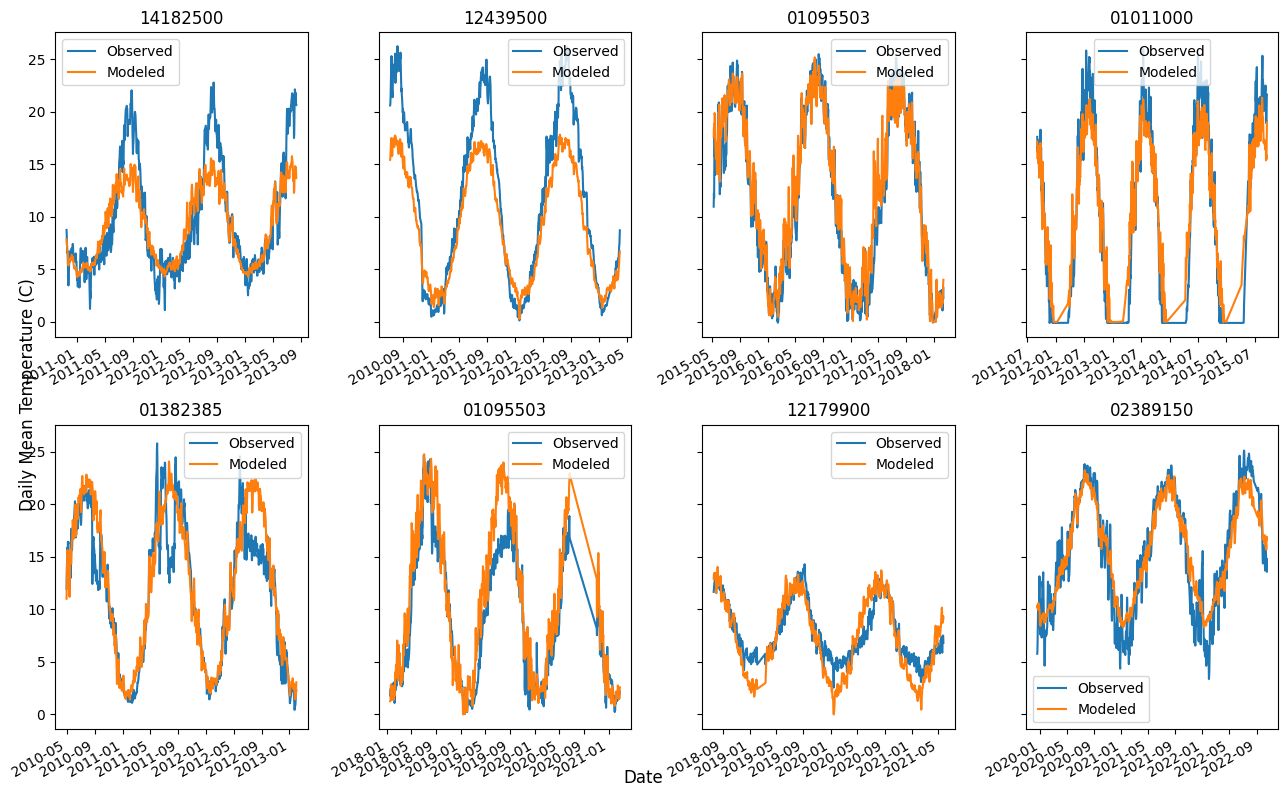

In [7]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8), sharey=True)
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(ID)

plt.tight_layout()
fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/SmarterGAMSample.png", dpi=1000)